## Requirements

In [8]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lib.utils import encode_image_to_base64
from IPython.display import display, Markdown

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [9]:
image_path = "../diagrams/training_grid_pipeline.png"
base64_string = encode_image_to_base64(image_path)

# Create the Markdown string with the base64 image
markdown_string = f'![Text_Pipeline](data:image/png;base64,{base64_string})'

## Logistic Regression

La Regresión Logística es apropiada para el análisis de sentimientos por varias razones clave:

1. Características de Clasificación de Texto:
- Naturaleza Binaria/Multiclase: Maneja naturalmente tareas de clasificación, siendo adecuada para etiquetas de sentimiento (positivo/negativo/neutral o calificaciones de 1-5 estrellas)
- Salidas probabilísticas: Proporciona puntuaciones de probabilidad para cada clase, dando información sobre la confianza de la predicción
- Fronteras de decisión lineales: Funciona bien con datos de texto donde las características (palabras) suelen tener relaciones lineales con el sentimiento

2. Manejo de Características:
- Funciona bien con datos dispersos: Las representaciones de texto como TF-IDF crean matrices dispersas, y la regresión logística las maneja eficientemente
- Interpretabilidad de pesos: Cada palabra obtiene un peso interpretable, mostrando su contribución a cada clase de sentimiento
- Maneja datos de alta dimensionalidad: Puede trabajar eficazmente con vocabularios grandes (muchas características)

3. Ventajas de Entrenamiento:
- Computacionalmente eficiente: Entrenamiento más rápido comparado con modelos de deep learning, especialmente para conjuntos de datos pequeños
- Menos propenso al sobreajuste: Especialmente cuando se usa regularización (L1/L2)
- Requiere menos datos: Puede funcionar bien con conjuntos de datos más pequeños en comparación con modelos más complejos

4. Beneficios Prácticos:
- Fácil de implementar y mantener
- Altamente escalable
- Tiempo de inferencia rápido
- Simple de actualizar con nuevos datos
- Análisis claro de importancia de características

5. Opciones de Regularización:
- L1 (Lasso): Ayuda con la selección de características al anular características irrelevantes
- L2 (Ridge): Previene el sobreajuste al restringir los pesos
- Elastic Net: Combina los beneficios de L1 y L2

Estas características hacen de la regresión logística un modelo base sólido para el análisis de sentimientos, especialmente cuando los recursos computacionales son limitados o cuando la interpretabilidad es importante.


Pipeline utilizado:
1. Transforms labels (1-5 to 0-4)
2. Sets up 4 different pipelines with TfidfVectorizer and LogisticRegression:
   - Basic pipeline
   - With scaling
   - With PCA (using TruncatedSVD)
   - With PCA and scaling
3. Runs GridSearchCV for each pipeline
4. Records and plots various metrics and visualizations

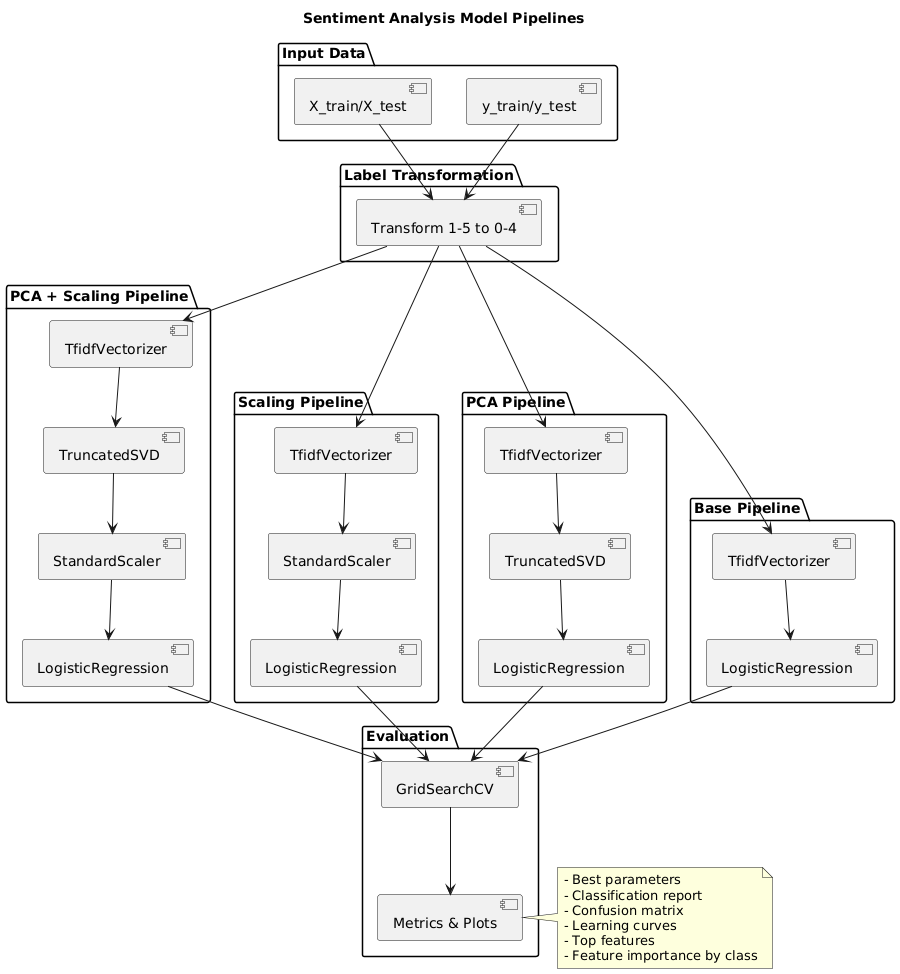

In [10]:
# Display the Markdown
display(Markdown(markdown_string))

## Data loader and split

In [6]:
dataset = pd.read_csv('../data/cleaned_dataset_processed_balanced.csv').sample(n=20508, random_state=42)
print(dataset.head(5))
print(dataset.shape)


                                                  review  rating  \
11368  great hotel just returned hotel stayed 24.08 3...       4   
2605   not worth price stayed whirlpool suite 269 nig...       3   
4518   great location clean rooms reviewers hotel gre...       4   
10638  service service, arrived renaissance friday ex...       2   
1962   Title: A Comfortable yet Imperfect Overnight D...       2   

       three_classes                                     cleaned_review  
11368              2  great returned originally petite double tight ...  
2605               1  not worth price whirlpool suite nice worth pri...  
4518               2  great location clean reviewers great bargain l...  
10638              0  service service arrived renaissance friday exp...  
1962               0  title comfortable yet imperfect overnight rece...  
(20508, 4)


In [7]:
def split_data_stratified(X, y, test_size=0.2, random_state=42):
    """
    Split data ensuring proportional representation of all classes
    """
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    
    # Get indices for train and test splits
    for train_idx, test_idx in sss.split(X, y):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
    
    print("Class distribution in splits:")
    print("\nTraining set:")
    print(y_train.value_counts().sort_index())
    print("\nTest set:")
    print(y_test.value_counts().sort_index())
    
    return X_train, X_test, y_train, y_test

In [29]:
X = dataset['cleaned_review']
y = dataset['rating']
y_three = dataset['three_classes']

X_train, X_test, y_train, y_test = split_data_stratified(X, y)

X_train_three, X_test_three, y_train_three, y_test_three = split_data_stratified(X, y_three)

Class distribution in splits:

Training set:
rating
1    2201
2    2498
3    2035
4    4030
5    5642
Name: count, dtype: int64

Test set:
rating
1     550
2     625
3     509
4    1007
5    1411
Name: count, dtype: int64
Class distribution in splits:

Training set:
three_classes
0    4699
1    2035
2    9672
Name: count, dtype: int64

Test set:
three_classes
0    1175
1     509
2    2418
Name: count, dtype: int64


## Functions and pipelines

In [30]:
def create_param_grids():
    """Define parameter grids for each model"""
    param_grids = {
        'Logistic Regression': {
            'vectorizer__max_features': [1000, 3000, 8000, 10000, 15000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'classifier__C': [0.1, 1.0, 10.0, 12.0],
            'classifier__class_weight': ['balanced'],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['saga', 'liblinear']
        },
        'With Scaling': {
            'vectorizer__max_features': [1000, 3000, 8000, 10000, 15000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'scaler__with_mean': [False],  # Correct way to parameterize scaler
            'classifier__C': [0.1, 1.0, 10.0, 12.0],
            'classifier__class_weight': ['balanced'],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['saga', 'liblinear']
        },
        'With PCA': {
            'vectorizer__max_features': [1000, 3000, 8000, 10000, 15000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'dim_reduction__n_components': [50, 100, 200],
            'classifier__C': [0.1, 1.0, 10.0, 12.0],
            'classifier__class_weight': ['balanced'],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['saga', 'liblinear']
        },
        'PCA + Scaling': {
            'vectorizer__max_features': [1000, 3000, 8000, 10000, 15000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'dim_reduction__n_components': [50, 100, 200],
            'scaler__with_mean': [False],  # Correct way to parameterize scaler
            'classifier__C': [0.1, 1.0, 10.0, 12.0],
            'classifier__class_weight': ['balanced'],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['saga', 'liblinear']
        },

    }
    return param_grids

In [31]:

def plot_learning_curves(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Plot learning curves for a given estimator"""
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_grid_search_results(grid_search, param_name):
    """Plot grid search results for a specific parameter"""
    # Clear any existing plots
    plt.clf()
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Get the parameter values
    param_values = [params[param_name] for params in results['params']]
    
    # Calculate mean scores for each parameter value
    mean_scores = {}
    std_scores = {}
    for value, mean, std in zip(param_values, 
                               results['mean_test_score'],
                               results['std_test_score']):
        if value not in mean_scores:
            mean_scores[value] = []
            std_scores[value] = []
        mean_scores[value].append(mean)
        std_scores[value].append(std)
    
    # Improved sorting function
    def sort_key(x):
        if x is None:
            return float('inf')  # Place None at the end
        return float(x) if isinstance(x, (int, float)) else str(x)
    
    # Separate numeric and None values
    numeric_values = [v for v in set(param_values) if v is not None]
    has_none = None in set(param_values)
    
    # Sort numeric values
    unique_values = sorted(numeric_values, key=float)
    if has_none:
        unique_values.append(None)
    
    # Calculate average for each parameter value
    mean_scores = [np.mean(mean_scores[value]) for value in unique_values]
    std_scores = [np.mean(std_scores[value]) for value in unique_values]
    
    # Convert values to strings for display
    x_labels = ['None' if v is None else str(v) for v in unique_values]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(range(len(unique_values)), mean_scores, 
                yerr=std_scores, fmt='o-')
    
    # Set the x-axis labels
    plt.xticks(range(len(unique_values)), x_labels, rotation=45)
    
    # Labels and title
    plt.xlabel(param_name)
    plt.ylabel('Mean CV Score')
    plt.title(f'Grid Search Results for {param_name}')
    plt.grid(True)
    
    # Add value labels
    for i, score in enumerate(mean_scores):
        plt.text(i, score, f'{score:.3f}', 
                horizontalalignment='center',
                verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_all_param_results(grid_search, param_grid):
    """Plot grid search results for all parameters"""
    n_params = len(param_grid)
    if n_params == 0:
        return
        
    # Calculate subplot layout
    n_cols = min(3, n_params)
    n_rows = (n_params + n_cols - 1) // n_cols
    
    plt.figure(figsize=(6*n_cols, 4*n_rows))
    
    for i, param_name in enumerate(param_grid.keys(), 1):
        plt.subplot(n_rows, n_cols, i)
        
        results = pd.DataFrame(grid_search.cv_results_)
        param_values = [params[param_name] for params in results['params']]
        
        # Custom sorting function that handles None
        def sort_key(x):
            if x is None:
                return float('inf')  # Place None at the end
            return x
        
        # Calculate mean scores for each parameter value
        mean_scores = {}
        std_scores = {}
        for value, mean, std in zip(param_values, 
                                   results['mean_test_score'],
                                   results['std_test_score']):
            if value not in mean_scores:
                mean_scores[value] = []
                std_scores[value] = []
            mean_scores[value].append(mean)
            std_scores[value].append(std)
        
        # Sort values handling None
        unique_values = sorted(set(param_values), key=sort_key)
        mean_scores = [np.mean(mean_scores[value]) for value in unique_values]
        std_scores = [np.mean(std_scores[value]) for value in unique_values]
        
        # Convert values to strings for display
        x_labels = ['None' if v is None else str(v) for v in unique_values]
        
        # Plot
        plt.errorbar(range(len(unique_values)), mean_scores, 
                    yerr=std_scores, fmt='o-')
        plt.xticks(range(len(unique_values)), x_labels, rotation=45)
        plt.xlabel(param_name)
        plt.ylabel('Mean CV Score')
        plt.title(f'Grid Search Results - {param_name}')
        plt.grid(True)
        
        # Add value labels
        for j, score in enumerate(mean_scores):
            plt.text(j, score, f'{score:.3f}', 
                    horizontalalignment='center',
                    verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()

def compare_models_with_grid_search(X_train, X_test, y_train, y_test, n_jobs=10, cv=3):
    # Transform labels from 1-5 to 0-4
    y_train_transformed = y_train - 1
    y_test_transformed = y_test - 1

    # Get number of unique classes
    n_classes = len(np.unique(np.concatenate([y_train_transformed, y_test_transformed])))
    
    # Define pipelines
    pipelines = {
        'Logistic Regression': Pipeline([
            ('vectorizer', TfidfVectorizer(
                min_df=10,
                max_df=0.95,)
             ),
            ('classifier', LogisticRegression(max_iter=6000))
        ]),      
        'With Scaling': Pipeline([
            ('vectorizer', TfidfVectorizer(
                min_df=10,
                max_df=0.95,)
             ),
            ('scaler', StandardScaler(with_mean=False)),
            ('classifier', LogisticRegression(max_iter=6000))
        ]), 
        'With PCA': Pipeline([
            ('vectorizer', TfidfVectorizer(
                min_df=10,
                max_df=0.95,)
             ),
            ('dim_reduction', TruncatedSVD(n_components=100)),
            ('classifier', LogisticRegression(max_iter=6000))
        ]),
        
        'PCA + Scaling': Pipeline([
            ('vectorizer', TfidfVectorizer(
                min_df=10,
                max_df=0.95,)
             ),
            ('dim_reduction', TruncatedSVD(n_components=100)),
            ('scaler', StandardScaler(with_mean=False)),
            ('classifier', LogisticRegression(max_iter=6000))
        ])
    }

    param_grids = create_param_grids()
    results = {}

    for name, pipeline in pipelines.items():
        print(f"\nTraining {name} with Grid Search...")
        
        # Perform grid search
        grid_search = GridSearchCV(
            pipeline,
            param_grids[name],
            cv=cv,
            n_jobs=n_jobs,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train_transformed)
        
        # Store best model results
        y_pred = grid_search.predict(X_test)
        y_pred_original = y_pred + 1
        y_test_original = y_test_transformed + 1

        results[name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'train_score': grid_search.score(X_train, y_train_transformed),
            'test_score': grid_search.score(X_test, y_test_transformed),
            'classification_report': classification_report(y_test_original, y_pred_original),
            'confusion_matrix': confusion_matrix(y_test_original, y_pred_original),
            'grid_search': grid_search
        }

        # Print results
        print(f"\n{name} Results:")
        print(f"Best parameters: {results[name]['best_params']}")
        print(f"Best CV score: {results[name]['best_score']:.3f}")
        print(f"Training accuracy: {results[name]['train_score']:.3f}")
        print(f"Testing accuracy: {results[name]['test_score']:.3f}")
        print("\nClassification Report:")
        print(results[name]['classification_report'])

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = results[name]['confusion_matrix']
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues')
        plt.title(f'{name} - Confusion Matrix (%)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Plot learning curves for best model
        plot_learning_curves(
            grid_search.best_estimator_,
            f'Learning Curves - {name}',
            X_train, y_train_transformed
        )

        # Plot grid search results for all parameters
        print(f"\nGrid Search Results for {name}:")
        plot_all_param_results(grid_search, param_grids[name])

        # Add this after other plots
        print(f"\nTop Features for {name}:")
        plot_top_features(grid_search.best_estimator_, name)
        print(f"\nClass-specific Features for {name}:")
        plot_top_features_by_class(grid_search.best_estimator_, name)

    return results

def plot_model_comparison(results):
    """Plot comparison of model performances"""
    try:
        # Prepare data
        models = list(results.keys())
        train_scores = [results[m]['train_score'] for m in models]
        test_scores = [results[m]['test_score'] for m in models]

        # Create plot
        x = np.arange(len(models))
        width = 0.35

        fig, ax = plt.subplots(figsize=(12, 6))
        rects1 = ax.bar(x - width/2, train_scores, width, label='Train')
        rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

        # Customize plot
        ax.set_ylabel('Accuracy')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45)
        ax.legend()

        # Add value labels
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.3f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),
                          textcoords="offset points",
                          ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in model comparison plot: {str(e)}")

def plot_top_features_by_class(model, model_name, n_features=10):
    """
    Plot top features for each class separately (for models that support it)
    """
    try:
        vectorizer = model.named_steps['vectorizer']
        feature_names = vectorizer.get_feature_names_out()
        
        if model_name in ['Logistic Regression', 'SVM']:
            coefficients = model.named_steps['classifier'].coef_
            n_classes = coefficients.shape[0]
            
            # Create subplot grid
            n_cols = 2
            n_rows = (n_classes + 1) // 2
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
            axes = axes.ravel()
            
            for i in range(n_classes):
                # Get top features for this class
                class_coef = coefficients[i]
                top_positive_idx = np.argsort(class_coef)[-n_features:]
                top_negative_idx = np.argsort(class_coef)[:n_features]
                
                # Plot
                ax = axes[i]
                y_pos = np.arange(n_features * 2)
                
                # Combine positive and negative features
                features = np.concatenate([
                    feature_names[top_negative_idx],
                    feature_names[top_positive_idx]
                ])
                importances = np.concatenate([
                    class_coef[top_negative_idx],
                    class_coef[top_positive_idx]
                ])
                
                ax.barh(y_pos, importances)
                ax.set_yticks(y_pos)
                ax.set_yticklabels(features)
                ax.set_title(f'Class {i+1} Important Features')
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Could not plot class-specific features for {model_name}: {str(e)}")

def plot_top_features(model, model_name, n_features=20):
    """
    Plot top n_features for each model
    """
    try:
        # Get vectorizer and feature names
        vectorizer = model.named_steps['vectorizer']
        feature_names = vectorizer.get_feature_names_out()
        
        # Get feature importance based on model type
        if model_name in ['Random Forest', 'XGBoost']:
            # Tree-based models
            importances = model.named_steps['classifier'].feature_importances_
            importance_type = 'Feature Importance'
        
        elif model_name == 'Logistic Regression':
            # Get absolute values of coefficients (average across classes for multiclass)
            importances = np.abs(model.named_steps['classifier'].coef_).mean(axis=0)
            importance_type = 'Coefficient Magnitude'
        
        elif model_name == 'SVM':
            # For LinearSVC, get coefficients from the underlying estimator
            importances = np.abs(model.named_steps['classifier'].estimator.coef_).mean(axis=0)
            importance_type = 'Coefficient Magnitude'
        
        elif model_name == 'Naive Bayes':
            # For Naive Bayes, use feature log probabilities
            importances = np.exp(model.named_steps['classifier'].feature_log_prob_).mean(axis=0)
            importance_type = 'Feature Probability'
        
        # Get top n features
        top_indices = np.argsort(importances)[-n_features:]
        top_features = feature_names[top_indices]
        top_importances = importances[top_indices]
        
        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(range(n_features), top_importances[::-1])
        plt.yticks(range(n_features), top_features[::-1])
        plt.xlabel(importance_type)
        plt.title(f'Top {n_features} Most Important Features - {model_name}')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not plot feature importance for {model_name}: {str(e)}")

## Train and Analysis

### Five classes


Training Logistic Regression with Grid Search...
Fitting 3 folds for each of 160 candidates, totalling 480 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Logistic Regression Results:
Best parameters: {'classifier__C': 1.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'vectorizer__max_features': 15000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.660
Training accuracy: 0.829
Testing accuracy: 0.664

Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.87      0.84       550
           2       0.75      0.62      0.68       625
           3       0.51      0.49      0.50       509
           4       0.53      0.49      0.51      1007
           5       0.71      0.79      0.75      1411

    accuracy                           0.66      4102
   macro avg       0.66      0.65      0.65      4102
weighted avg       0.66      0.66      0.66      4102



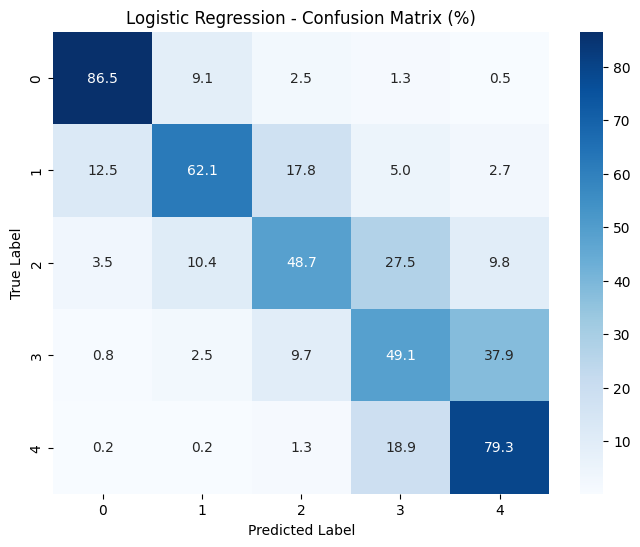

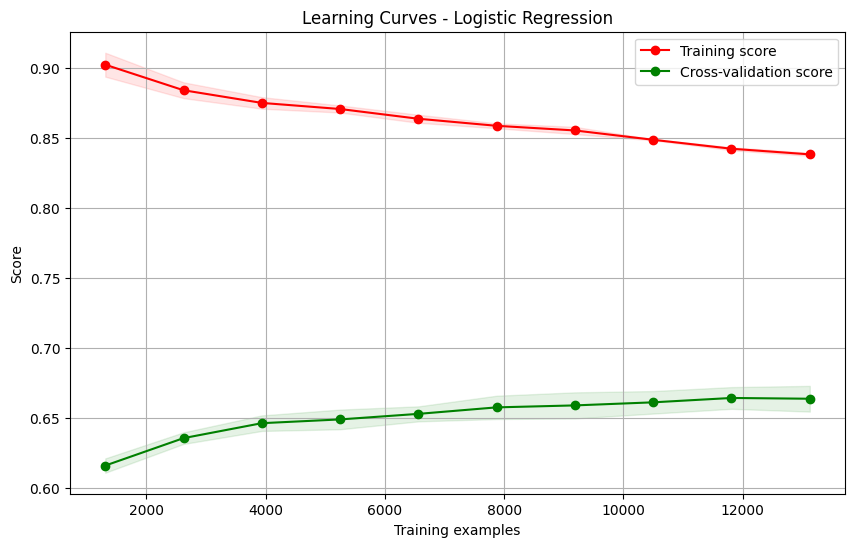


Grid Search Results for Logistic Regression:


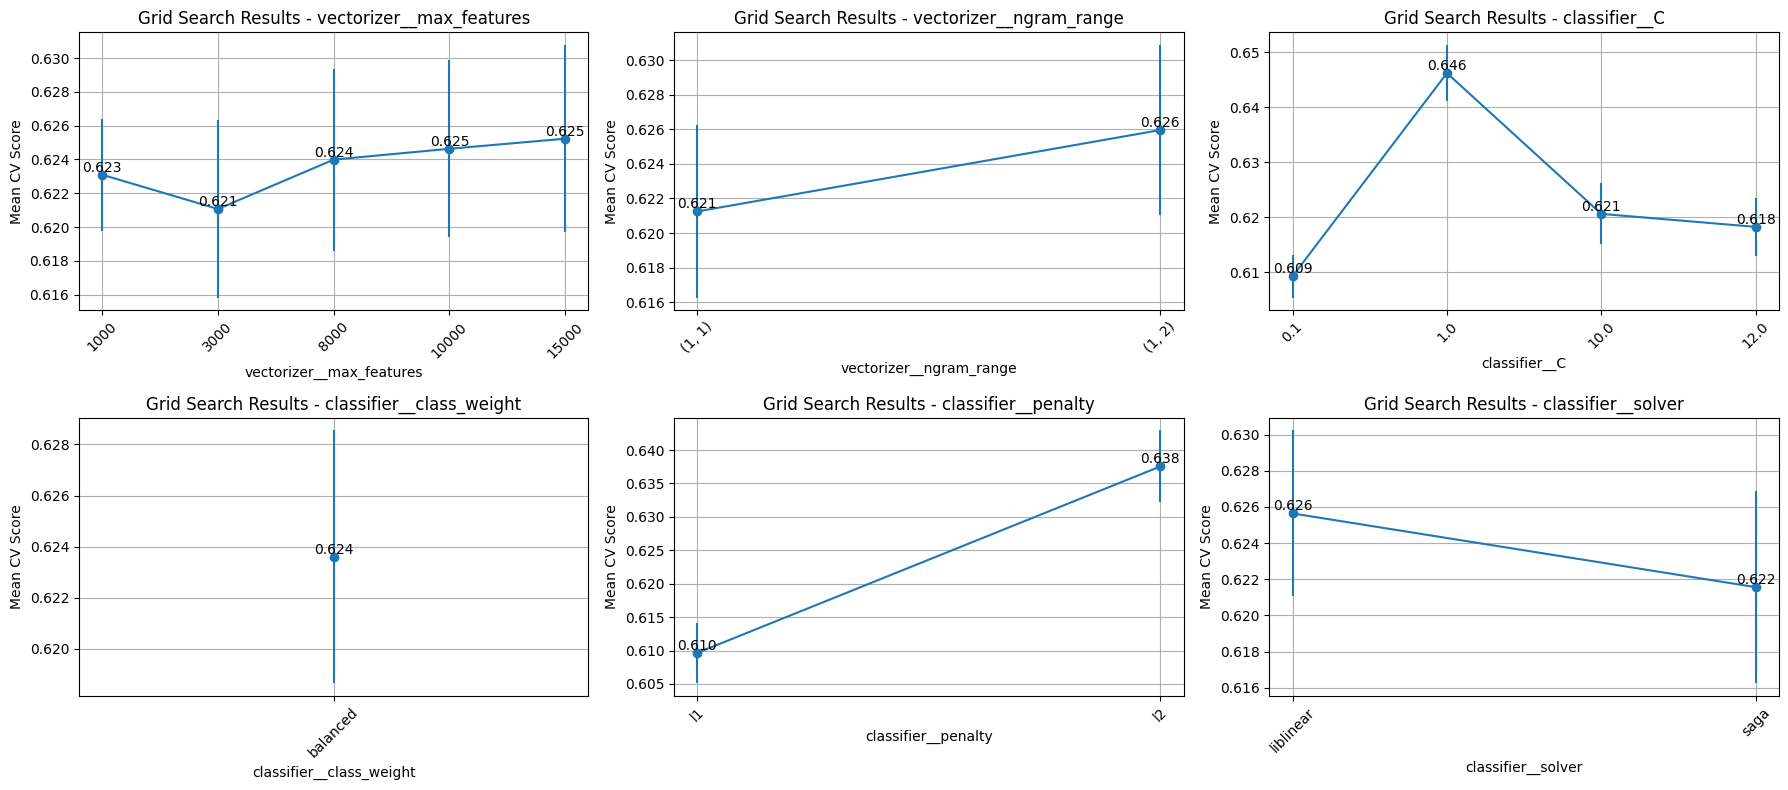


Top Features for Logistic Regression:


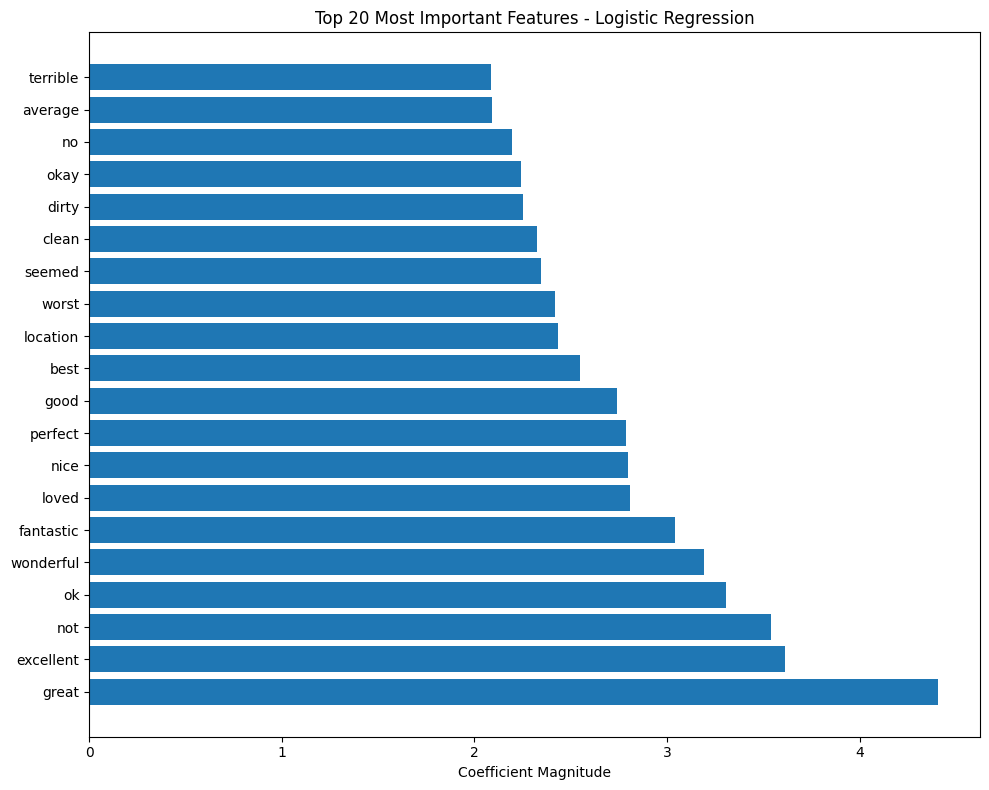


Class-specific Features for Logistic Regression:


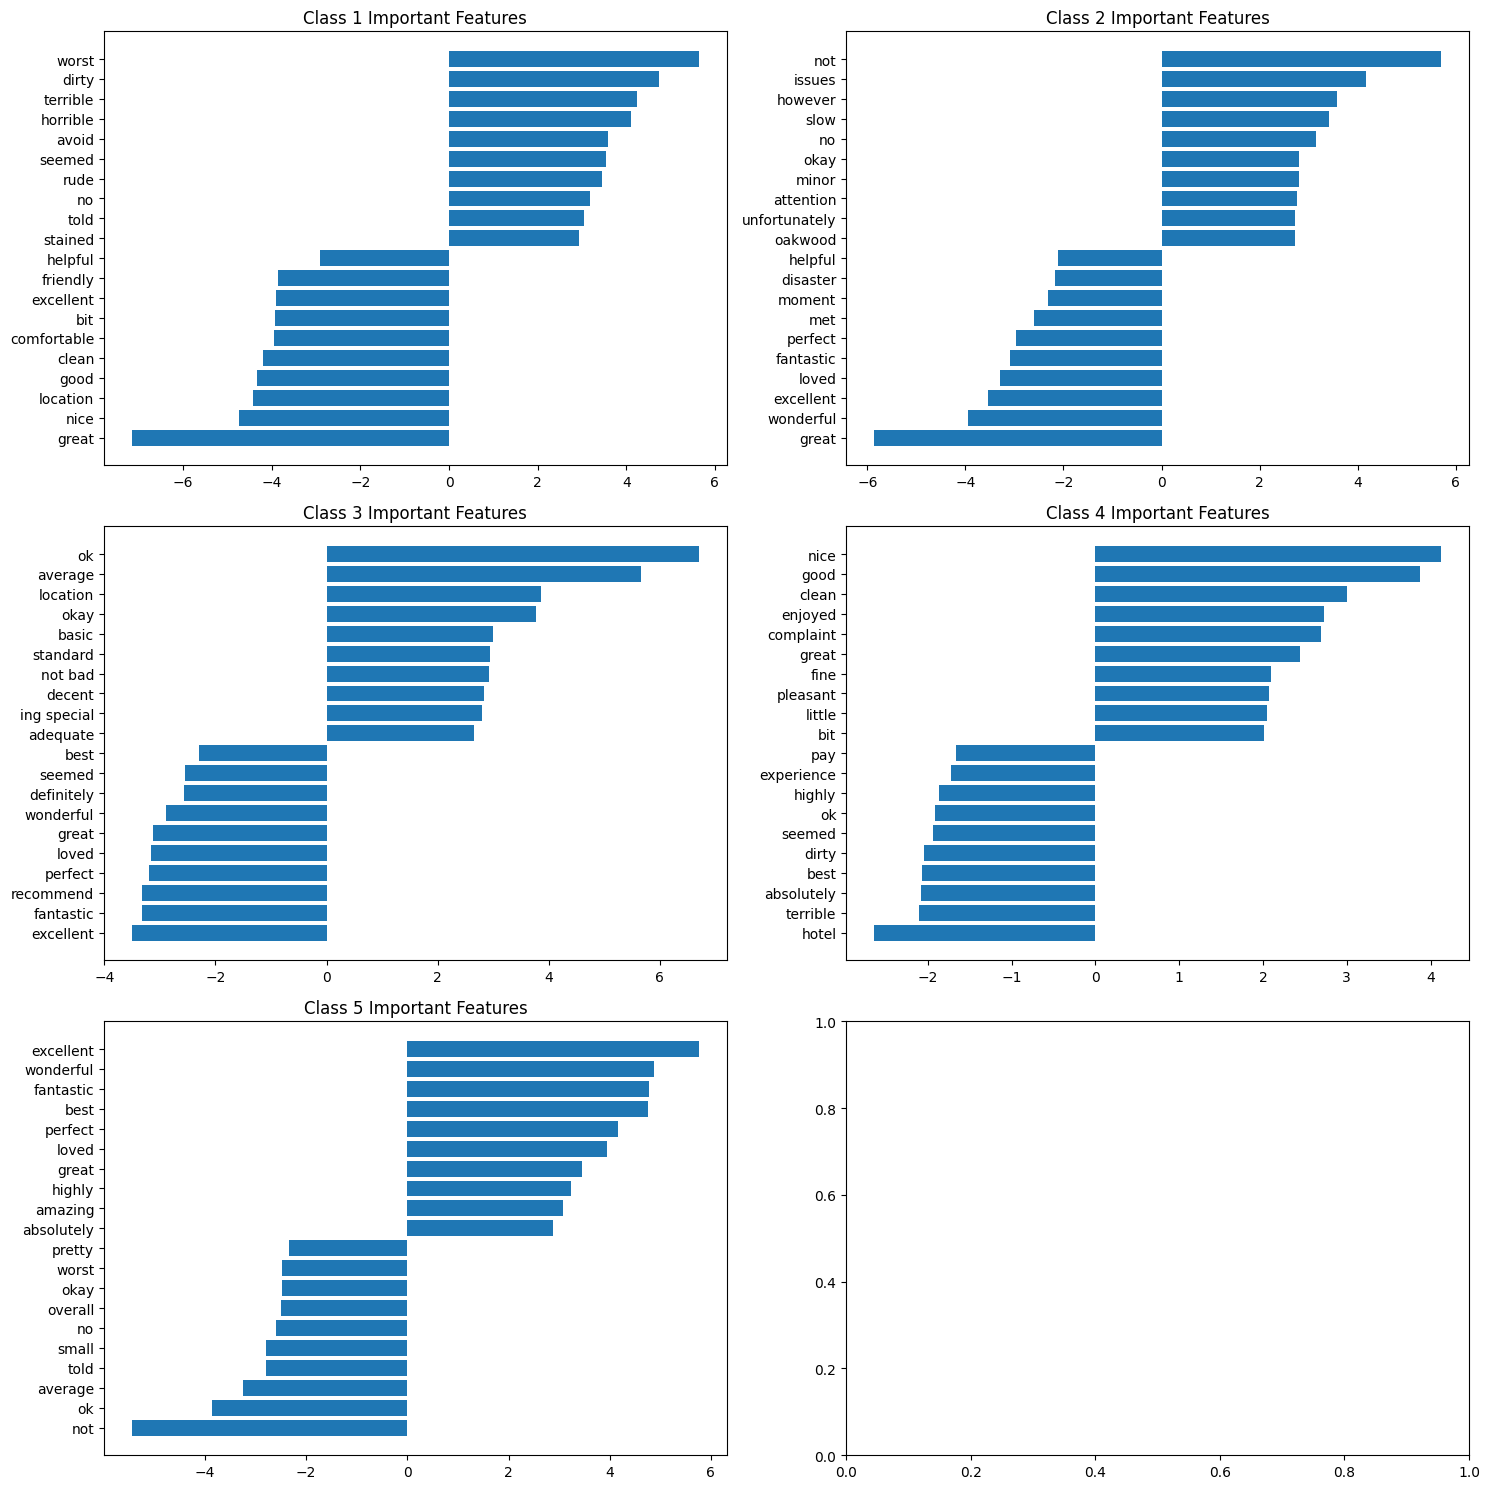


Training With Scaling with Grid Search...
Fitting 3 folds for each of 160 candidates, totalling 480 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


With Scaling Results:
Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'scaler__with_mean': False, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.632
Training accuracy: 0.731
Testing accuracy: 0.637

Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.82      0.80       550
           2       0.68      0.61      0.64       625
           3       0.46      0.48      0.47       509
           4       0.50      0.47      0.49      1007
           5       0.72      0.75      0.73      1411

    accuracy                           0.64      4102
   macro avg       0.63      0.63      0.63      4102
weighted avg       0.63      0.64      0.63      4102



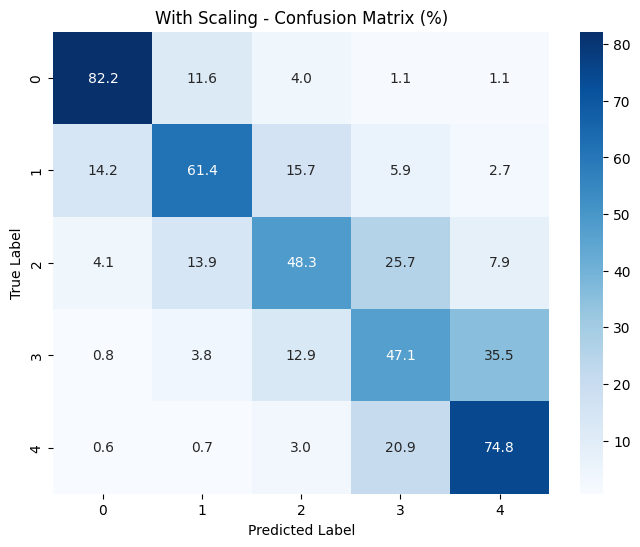

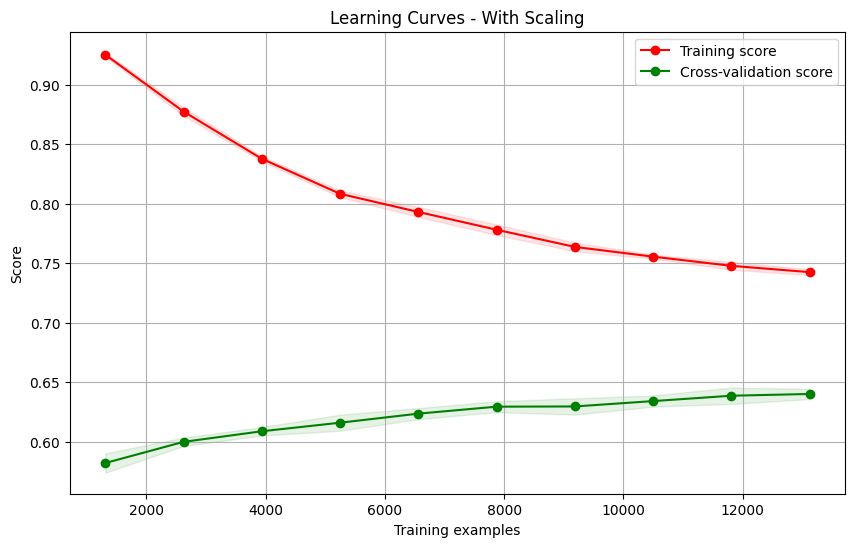


Grid Search Results for With Scaling:


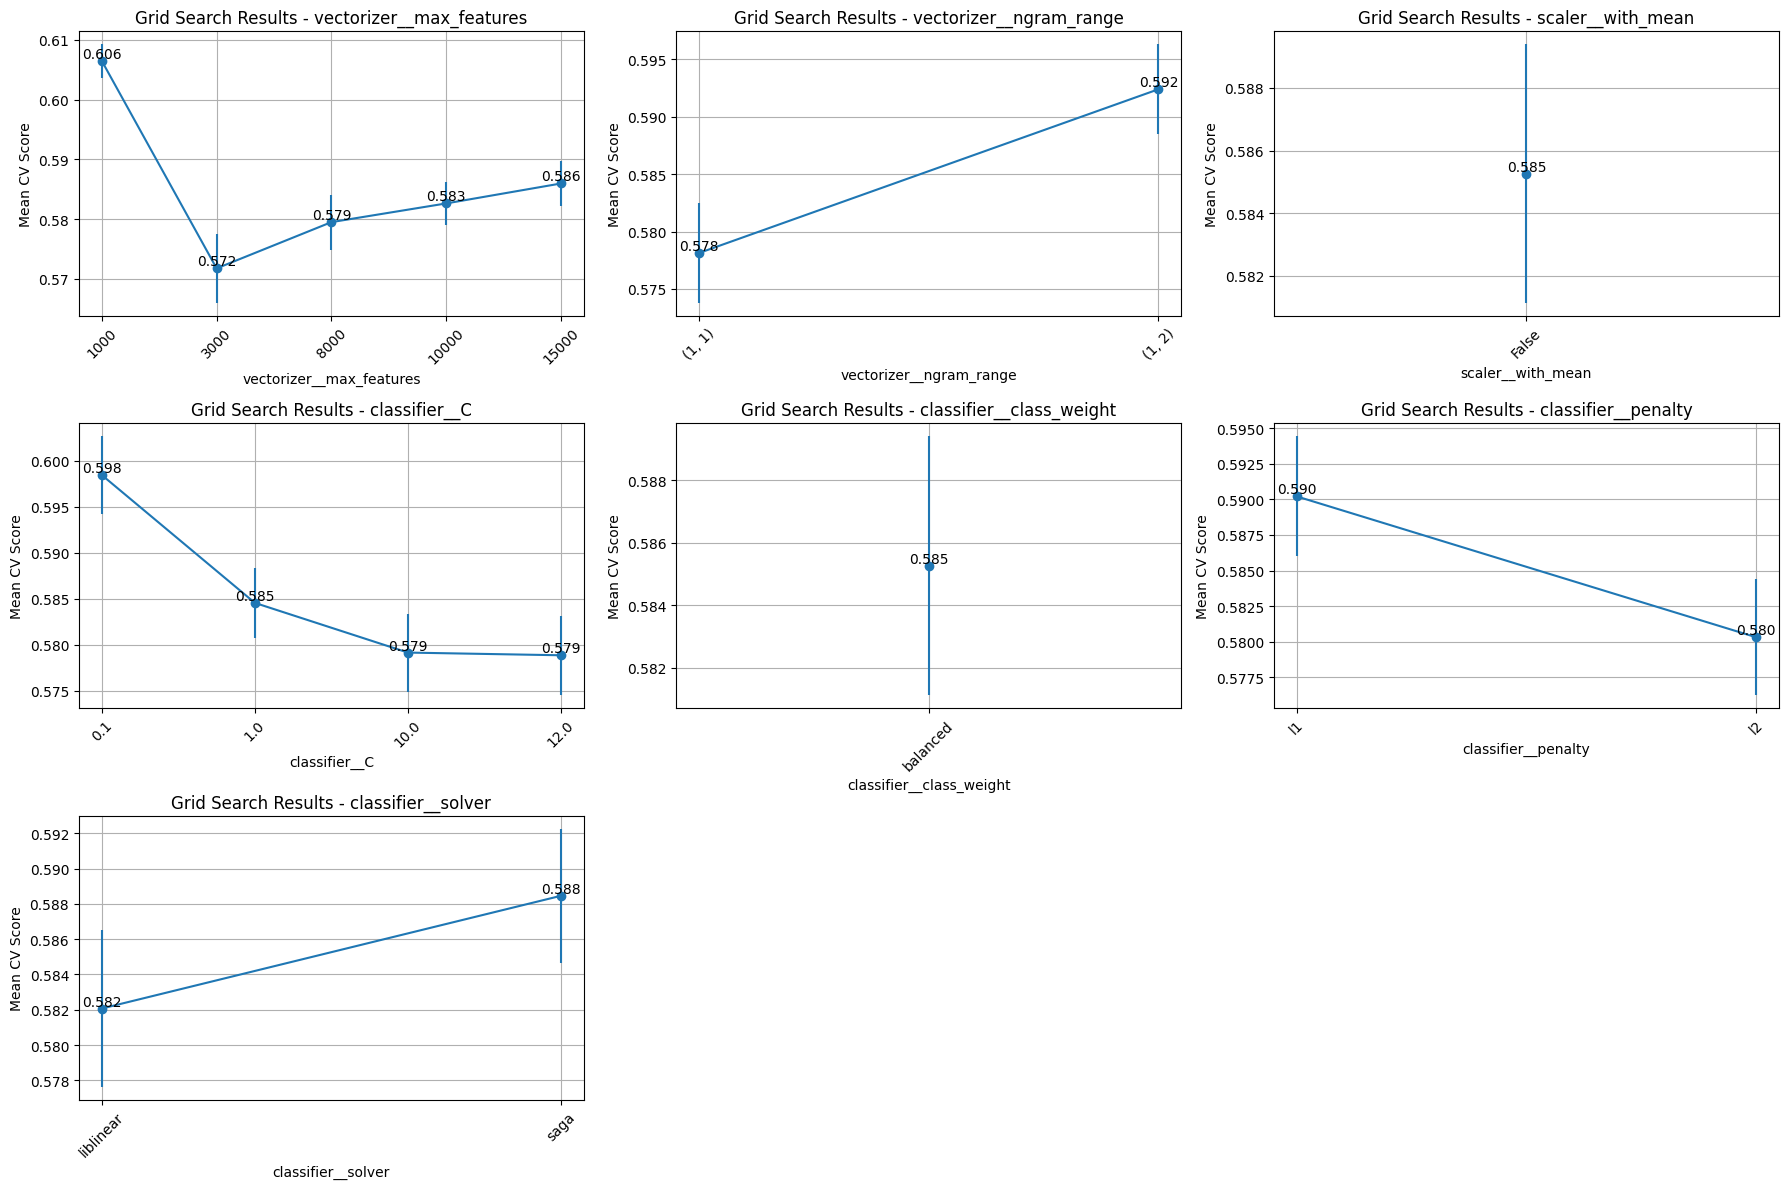


Top Features for With Scaling:
Could not plot feature importance for With Scaling: local variable 'importances' referenced before assignment

Class-specific Features for With Scaling:

Training With PCA with Grid Search...
Fitting 3 folds for each of 480 candidates, totalling 1440 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



With PCA Results:
Best parameters: {'classifier__C': 10.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'dim_reduction__n_components': 200, 'vectorizer__max_features': 15000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.660
Training accuracy: 0.685
Testing accuracy: 0.649

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.85      0.83       550
           2       0.73      0.65      0.69       625
           3       0.46      0.57      0.51       509
           4       0.50      0.53      0.51      1007
           5       0.76      0.69      0.72      1411

    accuracy                           0.65      4102
   macro avg       0.65      0.66      0.65      4102
weighted avg       0.66      0.65      0.65      4102



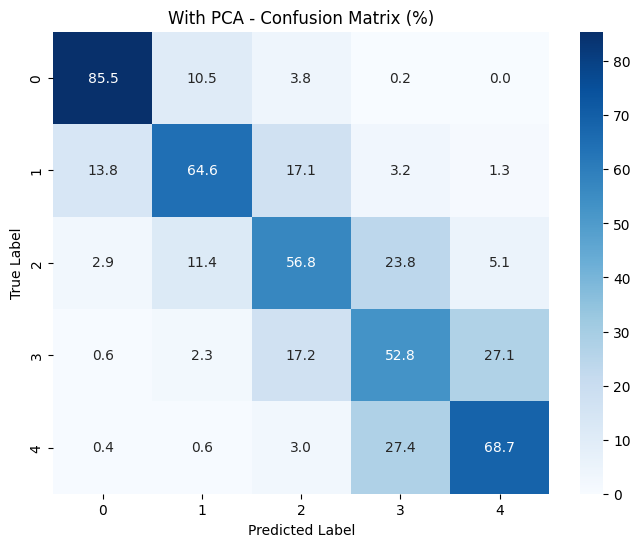

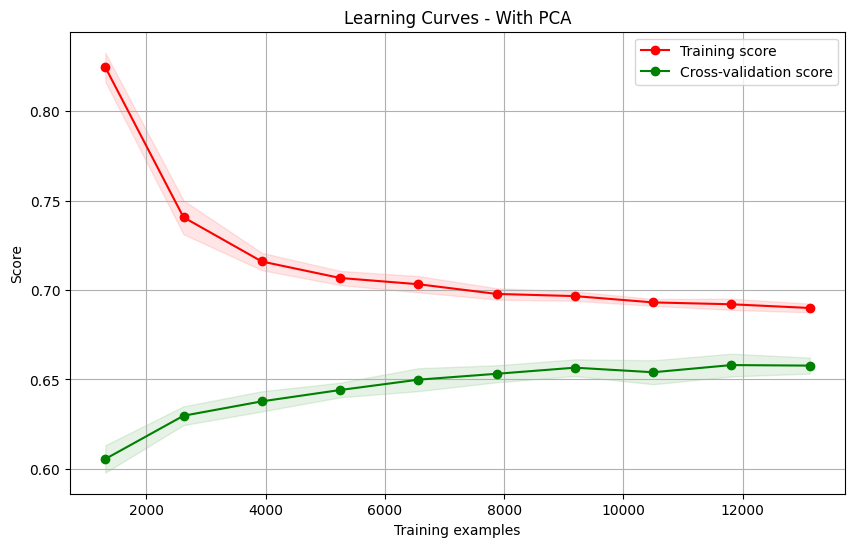


Grid Search Results for With PCA:


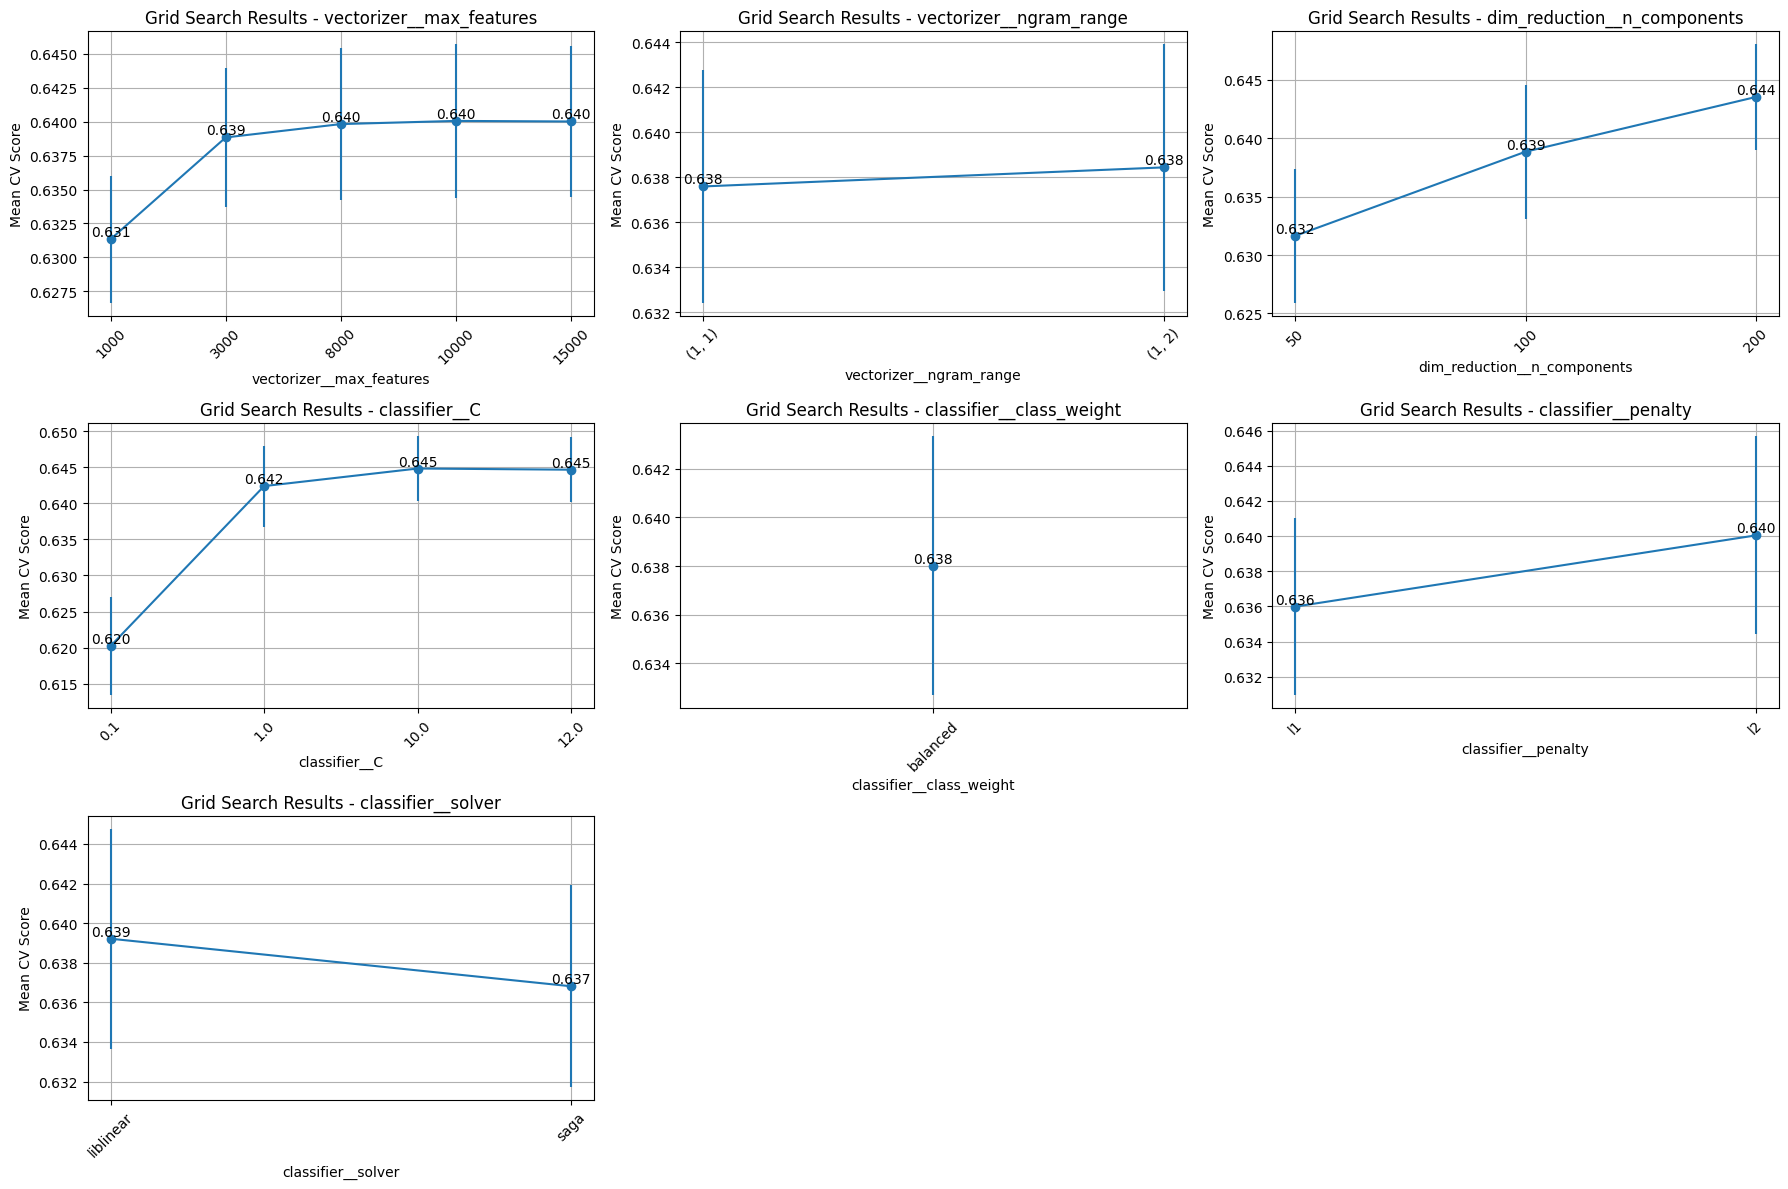


Top Features for With PCA:
Could not plot feature importance for With PCA: local variable 'importances' referenced before assignment

Class-specific Features for With PCA:

Training PCA + Scaling with Grid Search...
Fitting 3 folds for each of 480 candidates, totalling 1440 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



PCA + Scaling Results:
Best parameters: {'classifier__C': 1.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'dim_reduction__n_components': 200, 'scaler__with_mean': False, 'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.658
Training accuracy: 0.687
Testing accuracy: 0.649

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.85      0.83       550
           2       0.72      0.65      0.68       625
           3       0.46      0.57      0.51       509
           4       0.50      0.53      0.51      1007
           5       0.76      0.69      0.72      1411

    accuracy                           0.65      4102
   macro avg       0.65      0.66      0.65      4102
weighted avg       0.66      0.65      0.65      4102



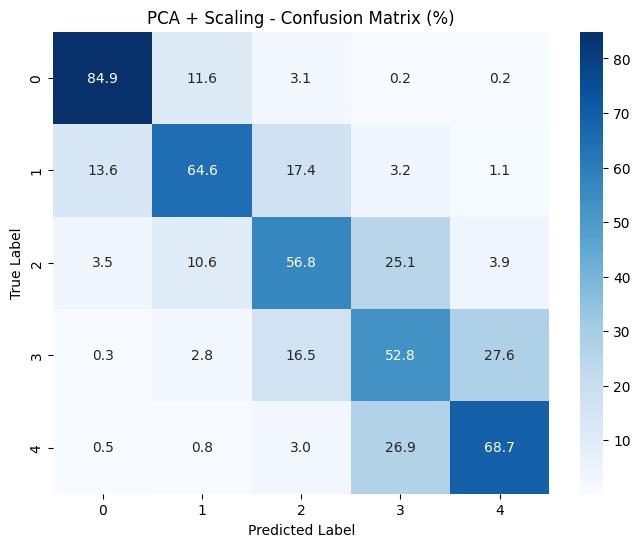

/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

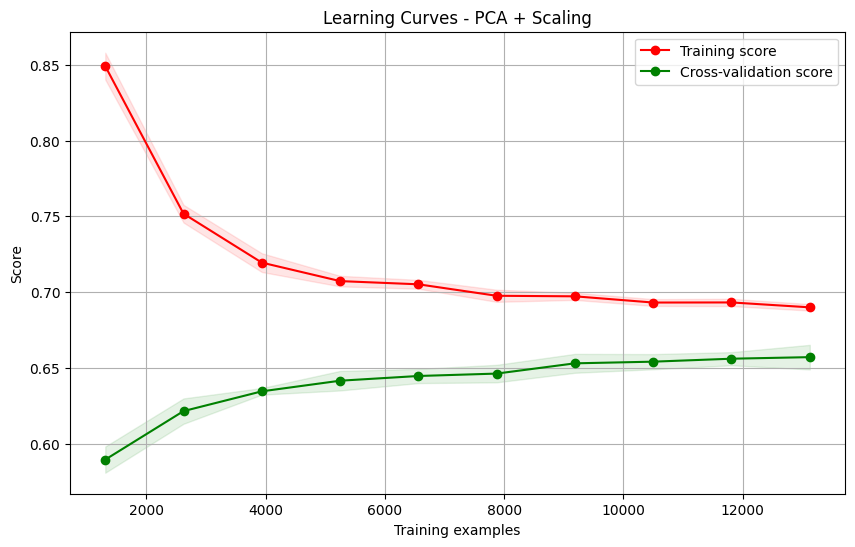


Grid Search Results for PCA + Scaling:


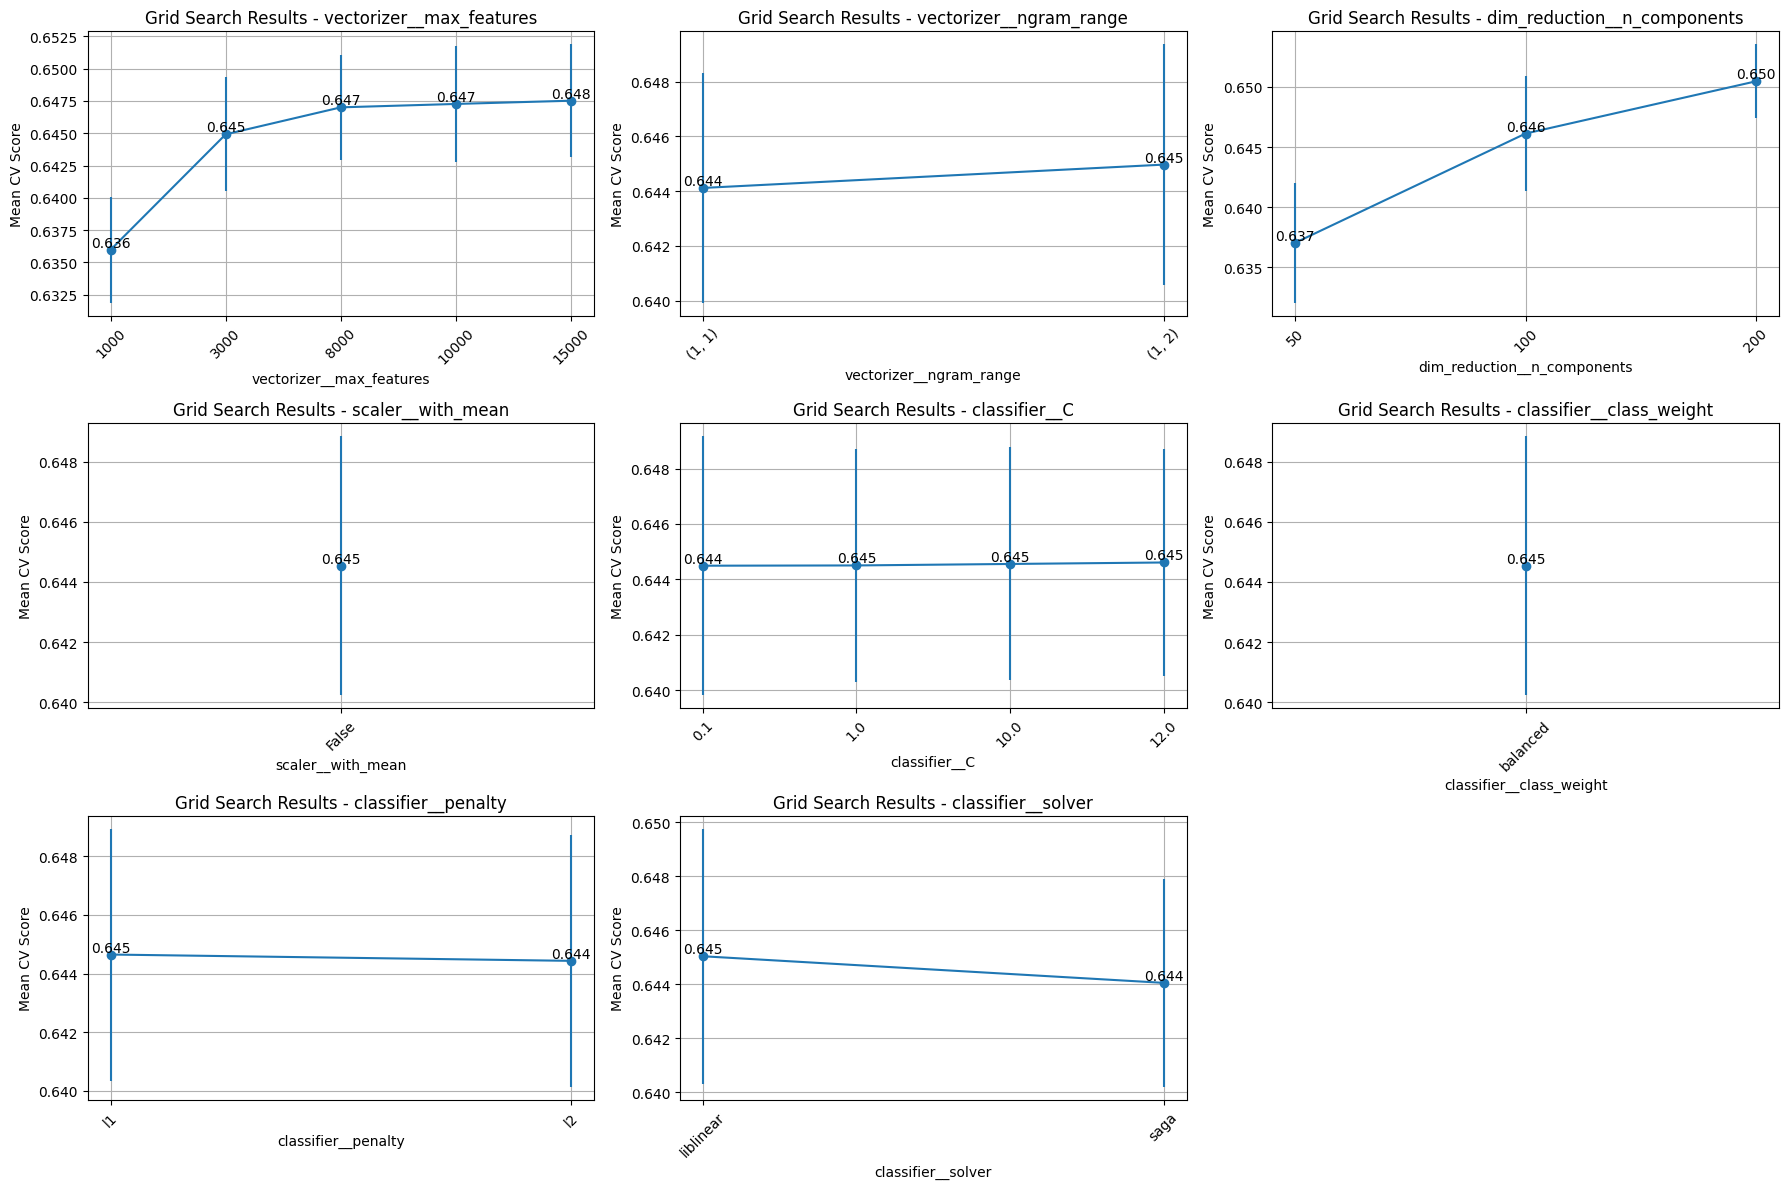


Top Features for PCA + Scaling:
Could not plot feature importance for PCA + Scaling: local variable 'importances' referenced before assignment

Class-specific Features for PCA + Scaling:


In [32]:
# Compare models
results = compare_models_with_grid_search(X_train, X_test, y_train, y_test)

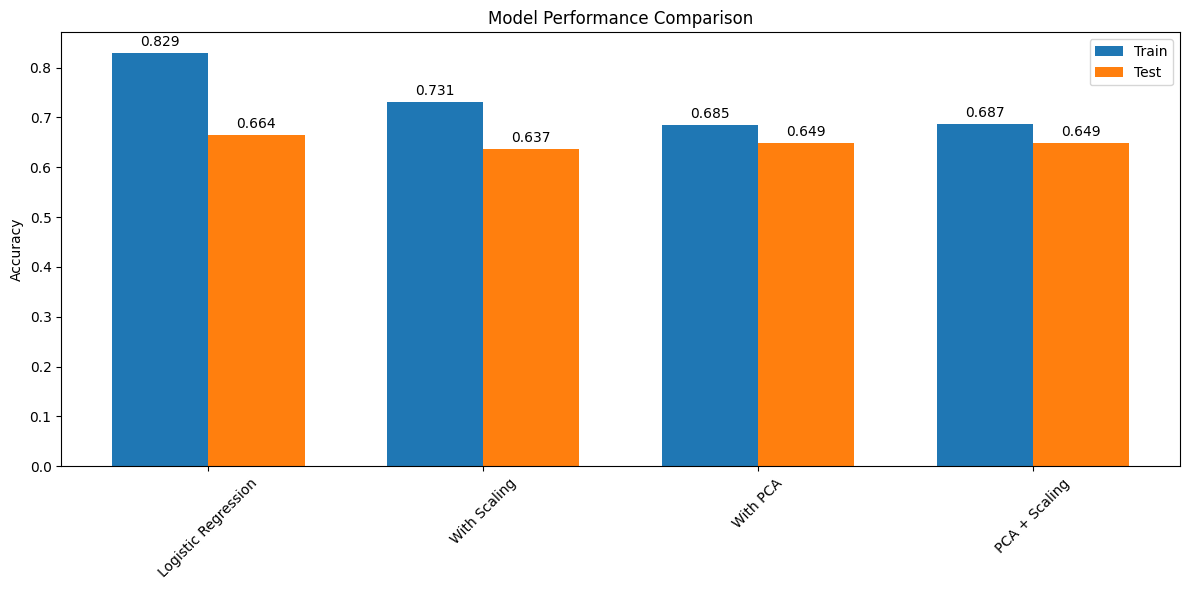

In [33]:
# Plot comparison
plot_model_comparison(results)

### Three classes


Training Logistic Regression with Grid Search...
Fitting 3 folds for each of 160 candidates, totalling 480 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Logistic Regression Results:
Best parameters: {'classifier__C': 1.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'vectorizer__max_features': 15000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.867
Training accuracy: 0.929
Testing accuracy: 0.862

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1175
           1       0.54      0.45      0.49       509
           2       0.89      0.94      0.92      2418

    accuracy                           0.86      4102
   macro avg       0.78      0.76      0.77      4102
weighted avg       0.85      0.86      0.86      4102



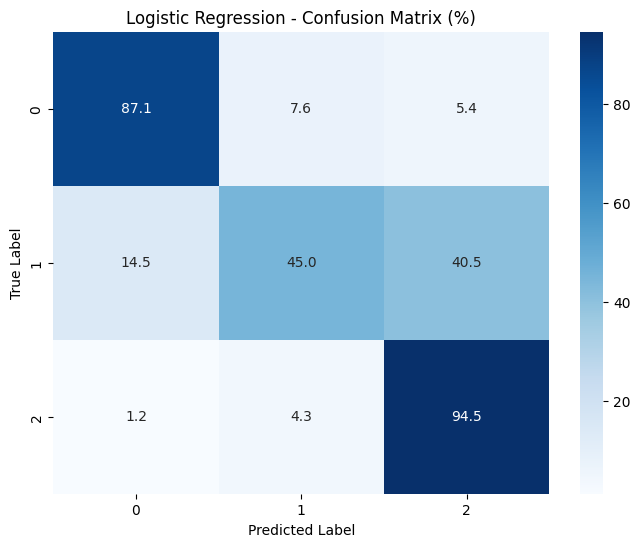

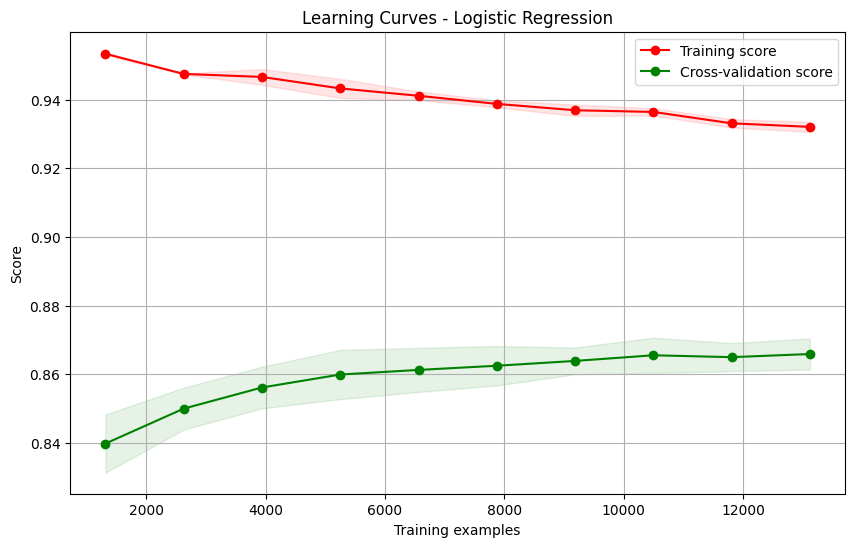


Grid Search Results for Logistic Regression:


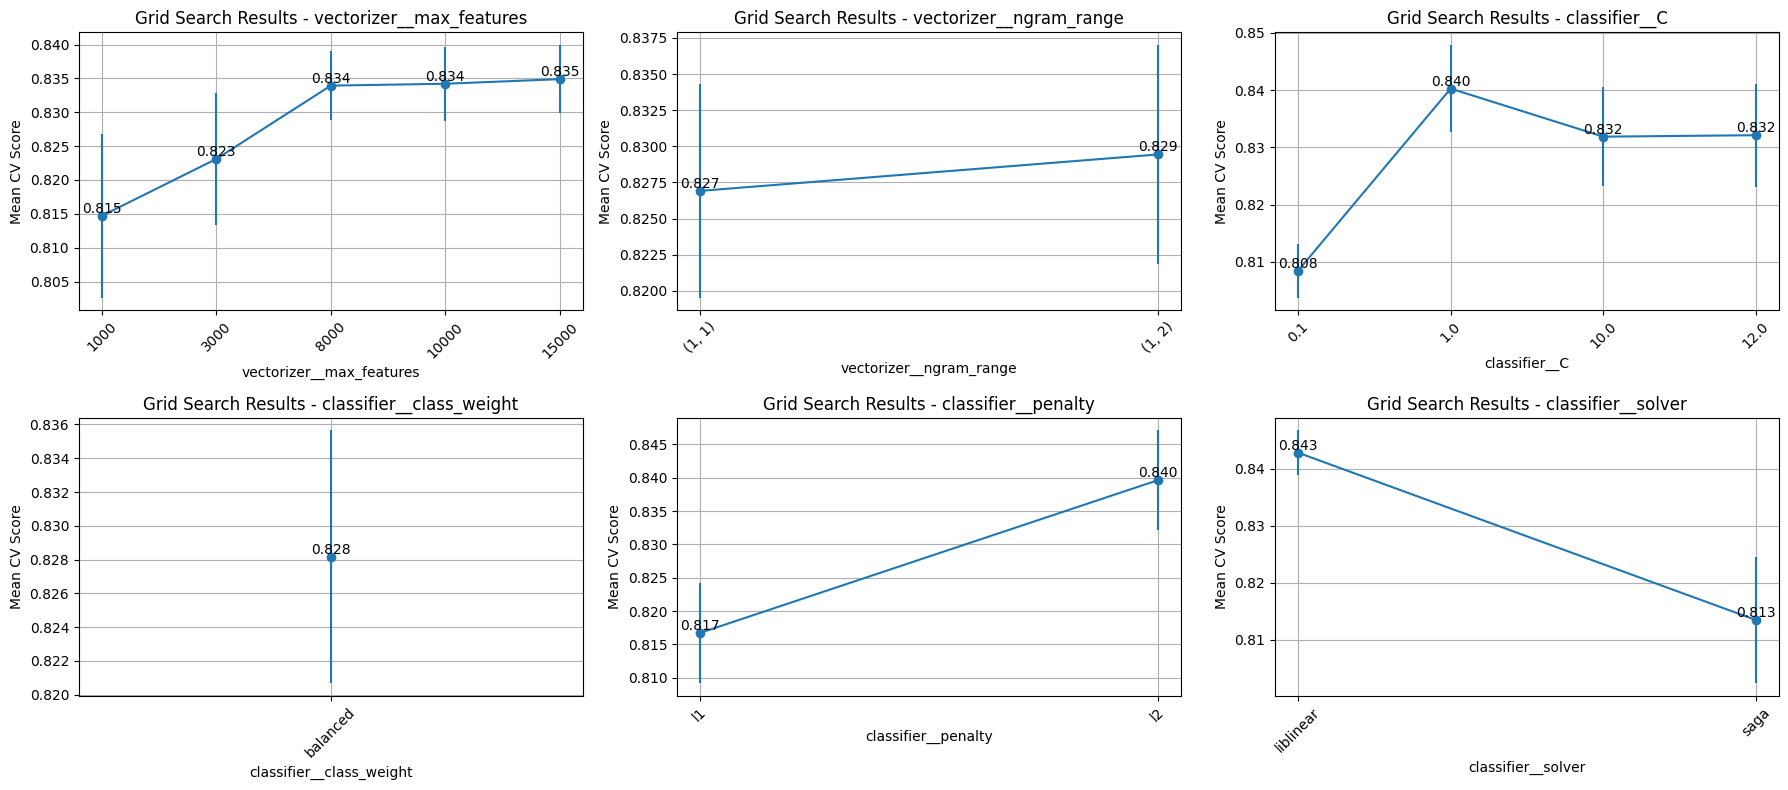


Top Features for Logistic Regression:


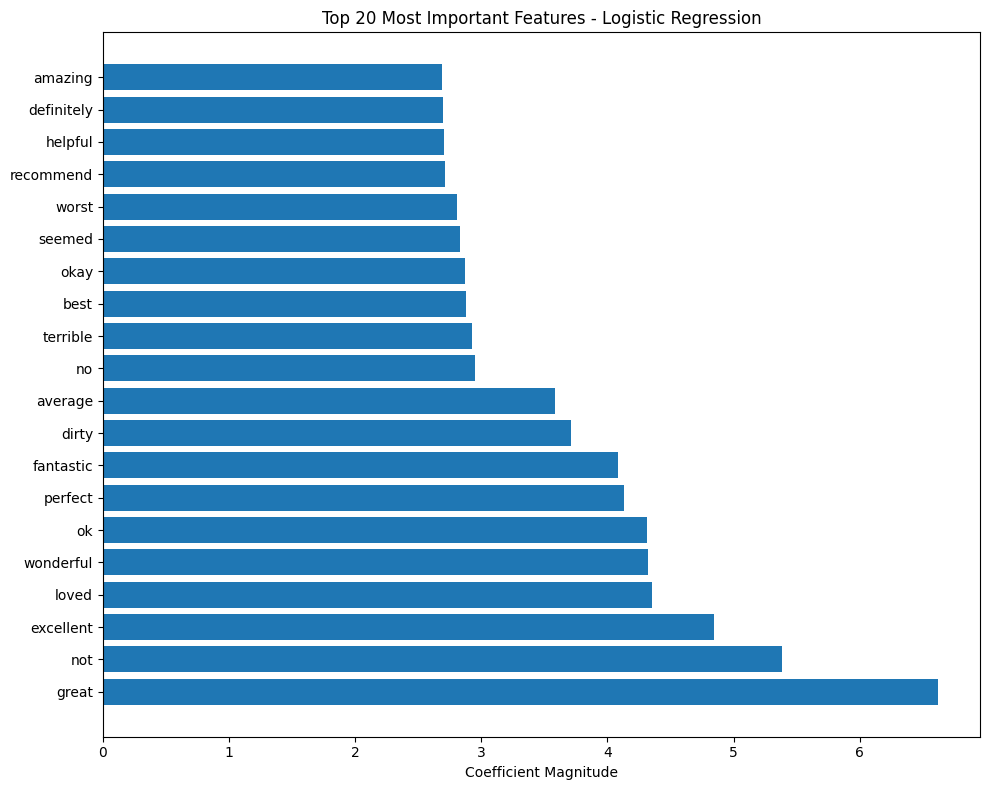


Class-specific Features for Logistic Regression:


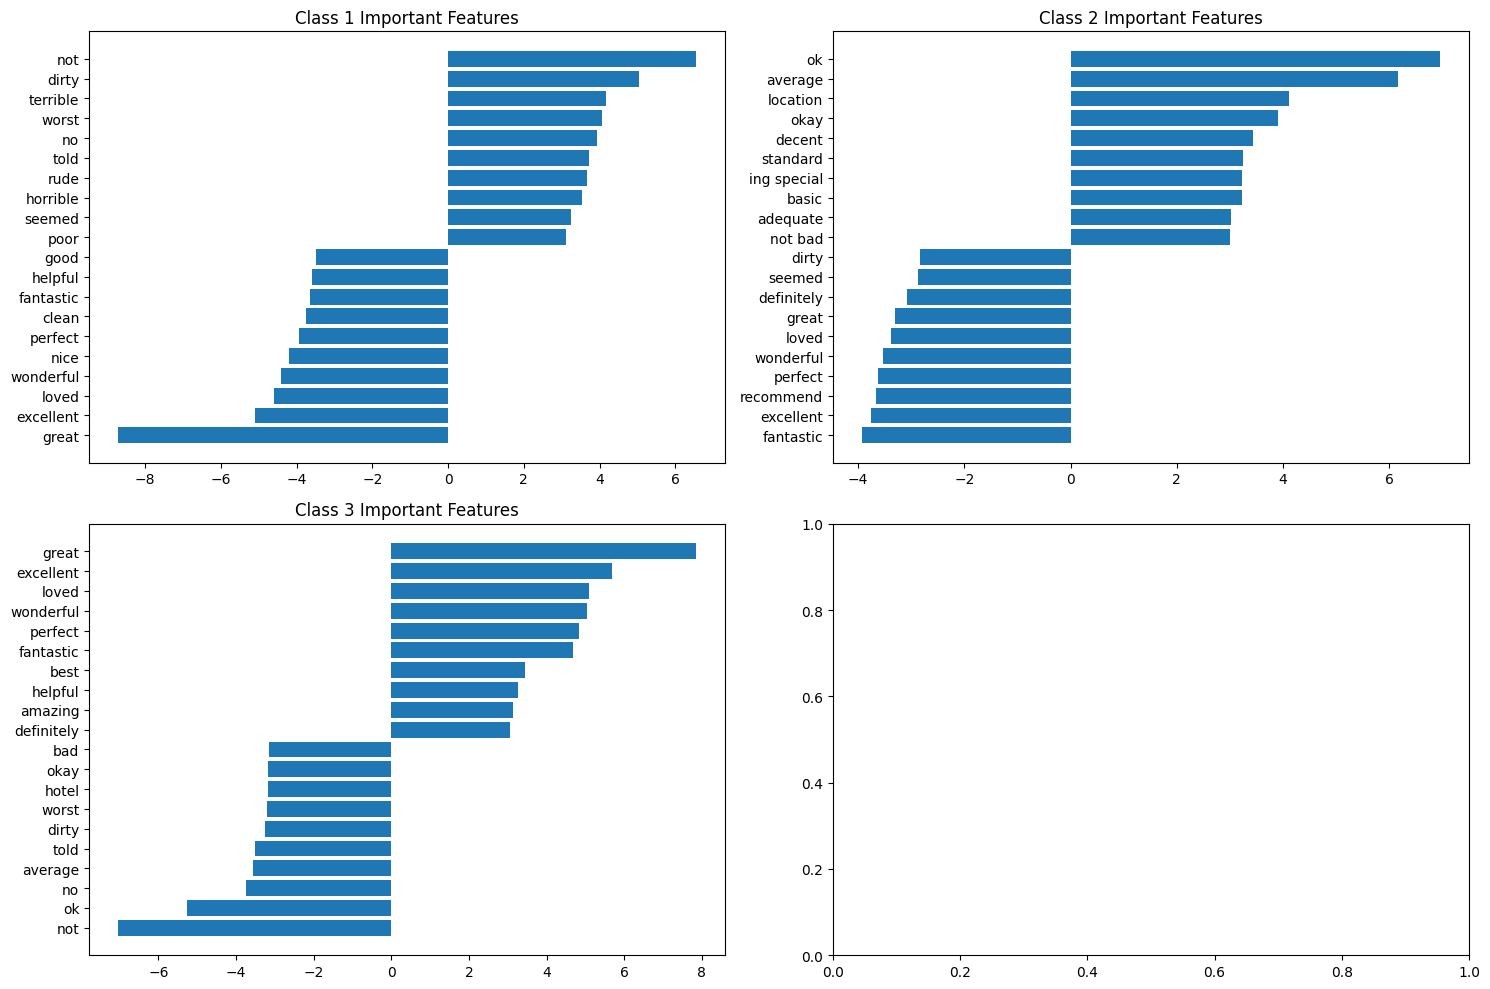


Training With Scaling with Grid Search...
Fitting 3 folds for each of 160 candidates, totalling 480 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


With Scaling Results:
Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'scaler__with_mean': False, 'vectorizer__max_features': 15000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.852
Training accuracy: 1.000
Testing accuracy: 0.838

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1175
           1       0.46      0.40      0.43       509
           2       0.89      0.92      0.91      2418

    accuracy                           0.84      4102
   macro avg       0.74      0.73      0.73      4102
weighted avg       0.83      0.84      0.83      4102



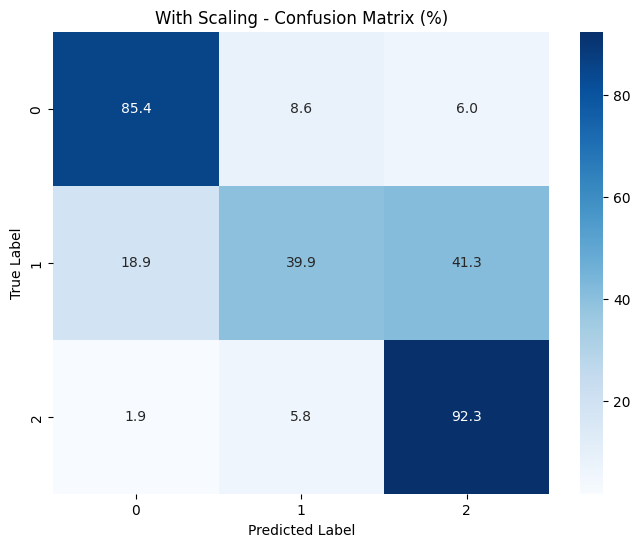

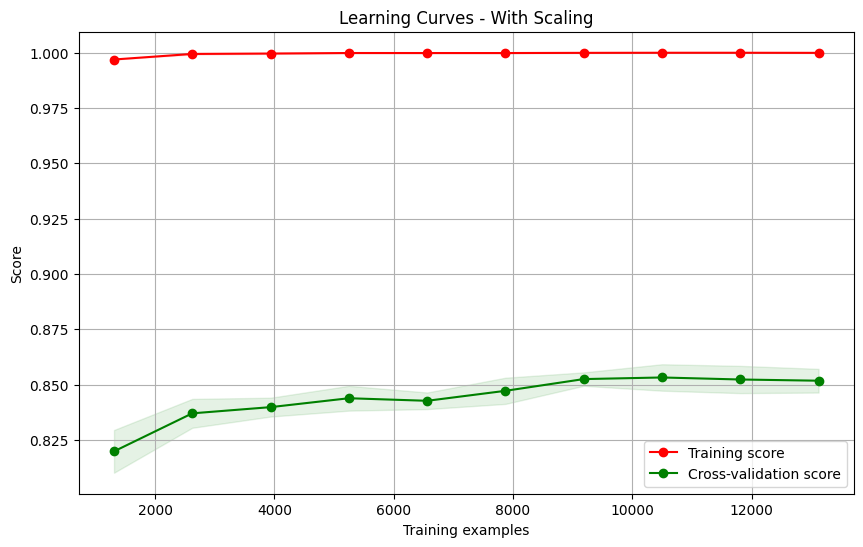


Grid Search Results for With Scaling:


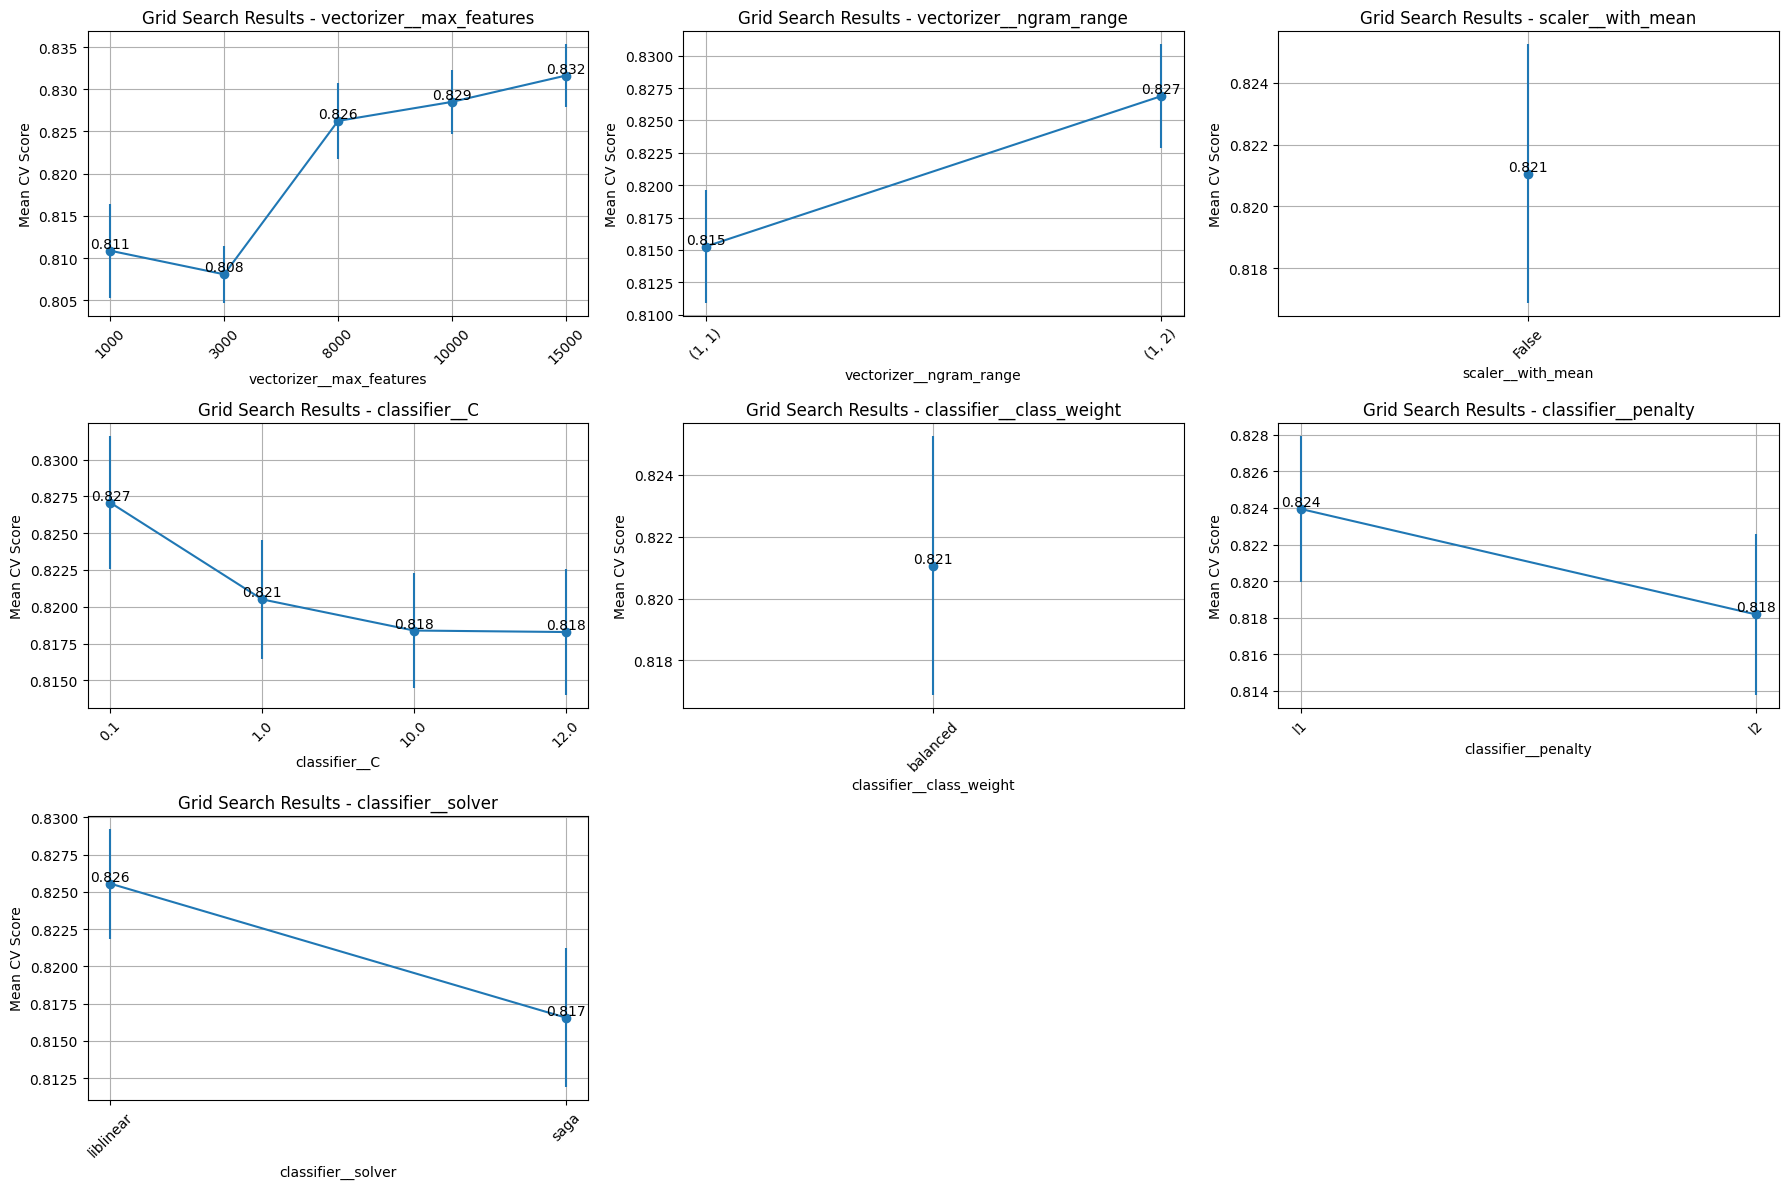


Top Features for With Scaling:
Could not plot feature importance for With Scaling: local variable 'importances' referenced before assignment

Class-specific Features for With Scaling:

Training With PCA with Grid Search...
Fitting 3 folds for each of 480 candidates, totalling 1440 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



With PCA Results:
Best parameters: {'classifier__C': 12.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'dim_reduction__n_components': 200, 'vectorizer__max_features': 15000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.859
Training accuracy: 0.870
Testing accuracy: 0.854

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1175
           1       0.50      0.47      0.48       509
           2       0.91      0.92      0.91      2418

    accuracy                           0.85      4102
   macro avg       0.77      0.76      0.76      4102
weighted avg       0.85      0.85      0.85      4102



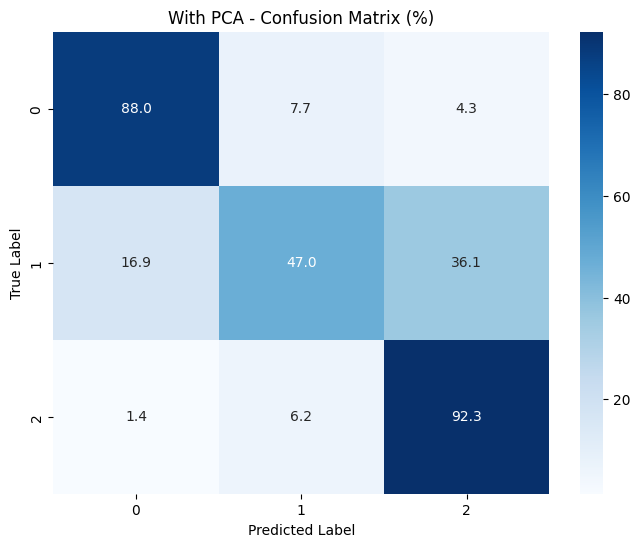

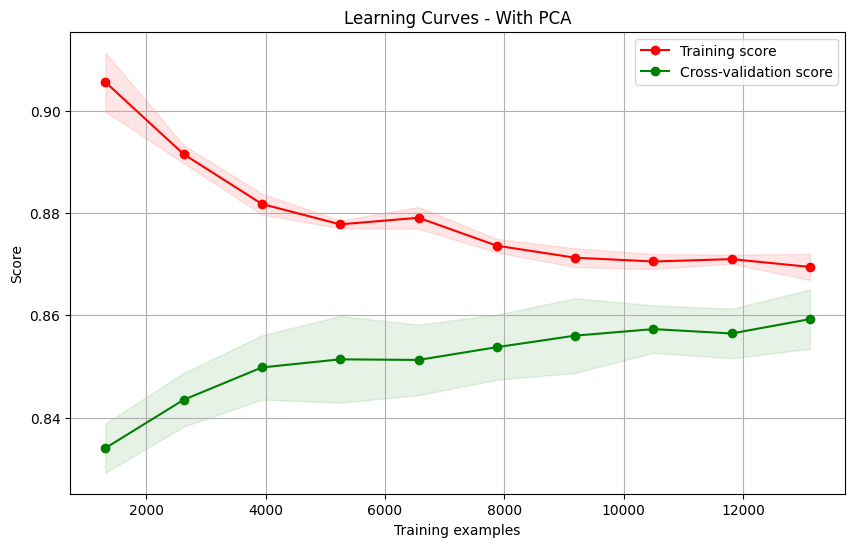


Grid Search Results for With PCA:


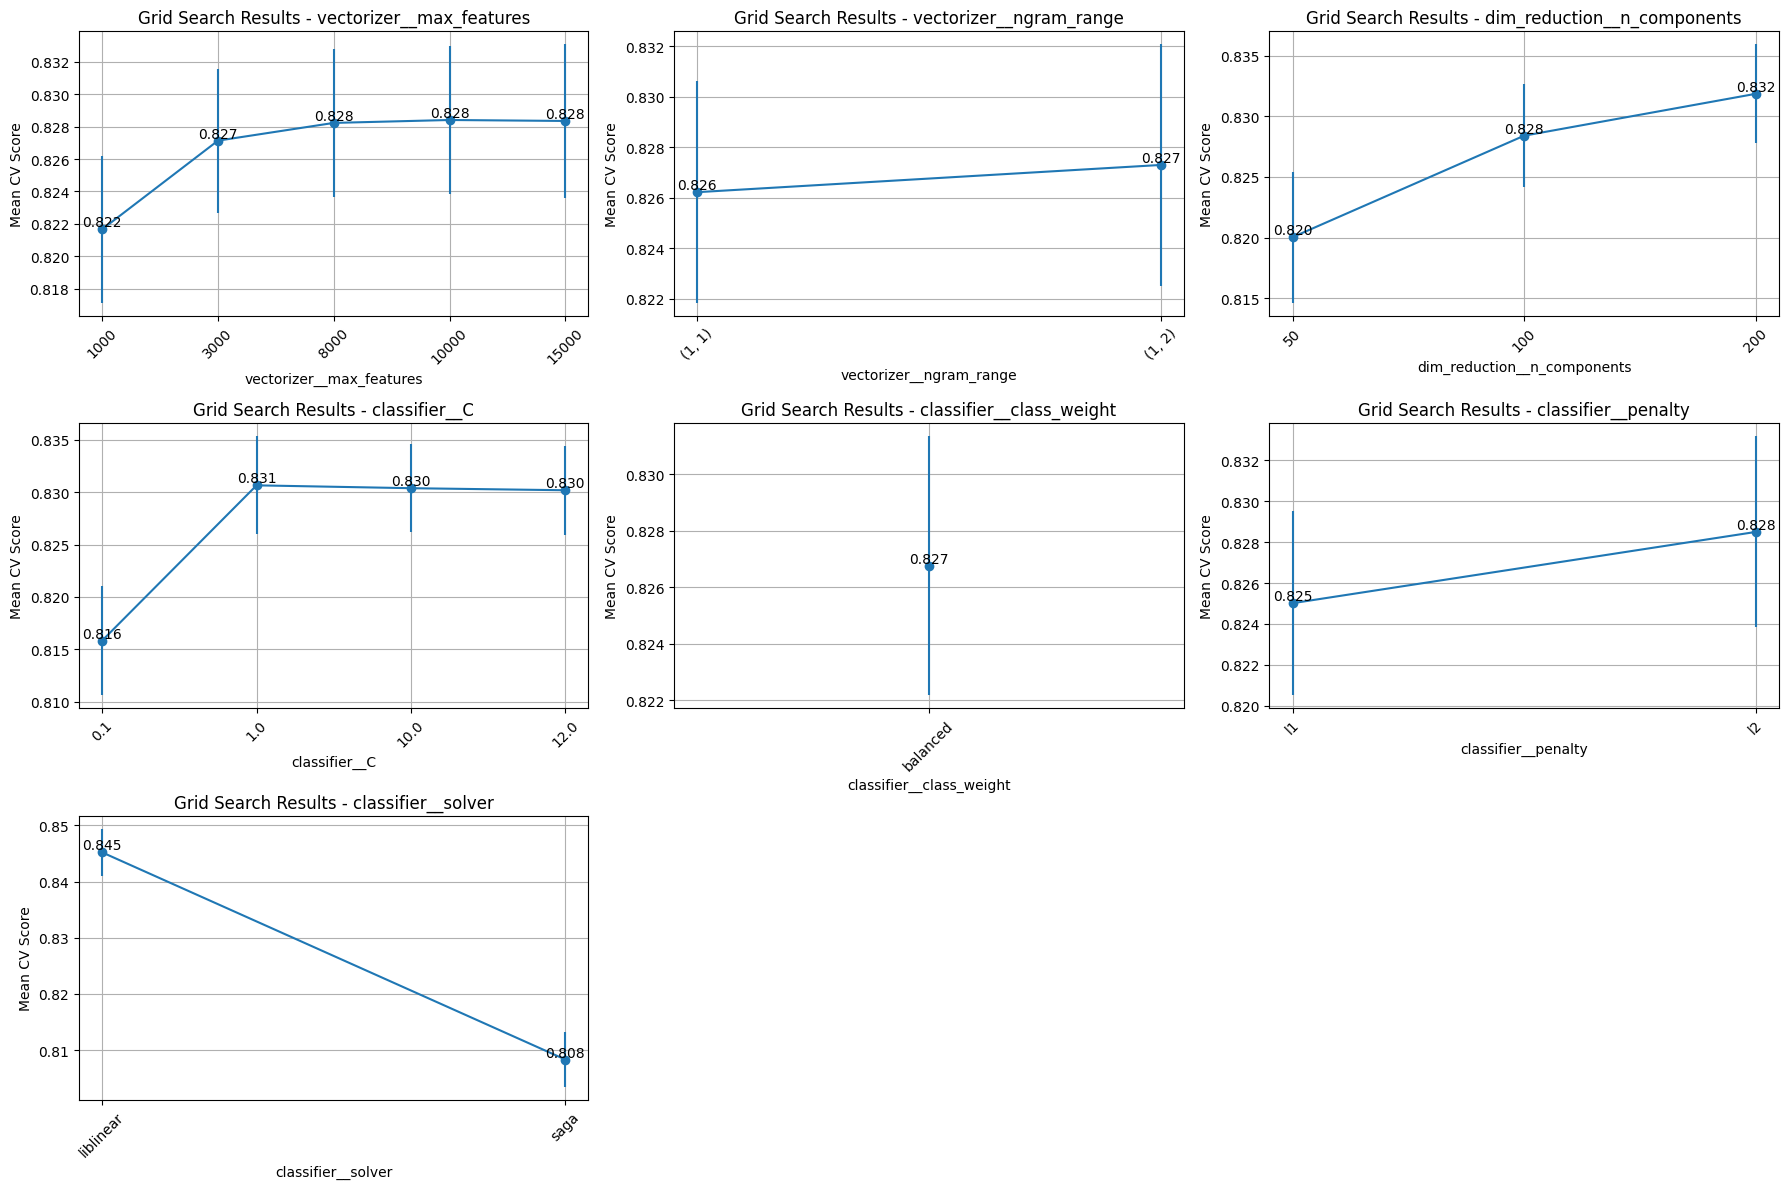


Top Features for With PCA:
Could not plot feature importance for With PCA: local variable 'importances' referenced before assignment

Class-specific Features for With PCA:

Training PCA + Scaling with Grid Search...
Fitting 3 folds for each of 480 candidates, totalling 1440 fits


/home/jgonzalez/dev/.virtualenv/AM1-TP/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



PCA + Scaling Results:
Best parameters: {'classifier__C': 1.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'dim_reduction__n_components': 200, 'scaler__with_mean': False, 'vectorizer__max_features': 15000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.859
Training accuracy: 0.868
Testing accuracy: 0.853

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1175
           1       0.50      0.46      0.48       509
           2       0.90      0.92      0.91      2418

    accuracy                           0.85      4102
   macro avg       0.76      0.75      0.76      4102
weighted avg       0.85      0.85      0.85      4102



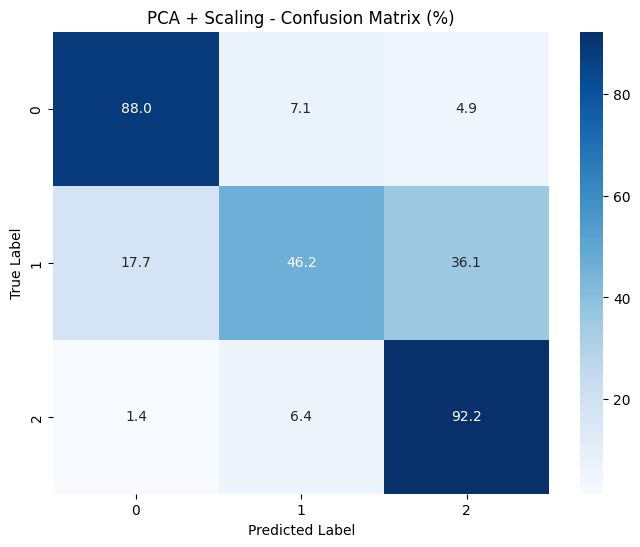

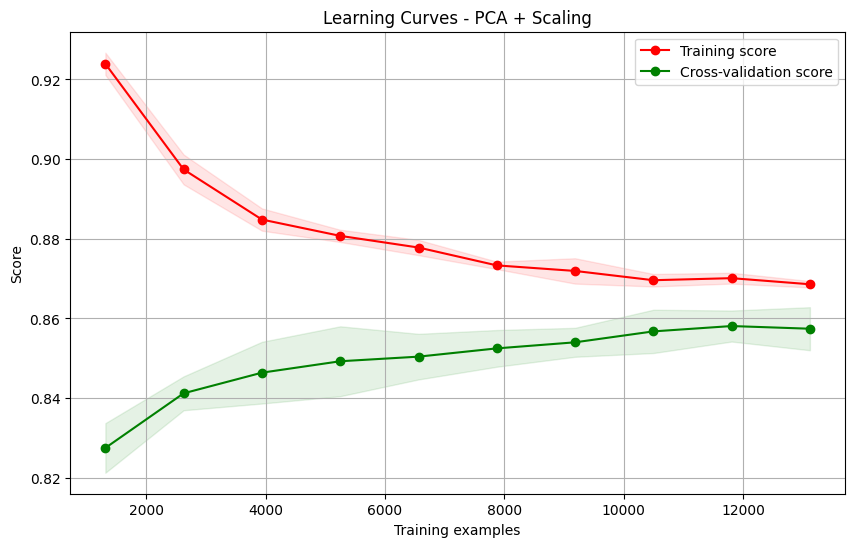


Grid Search Results for PCA + Scaling:


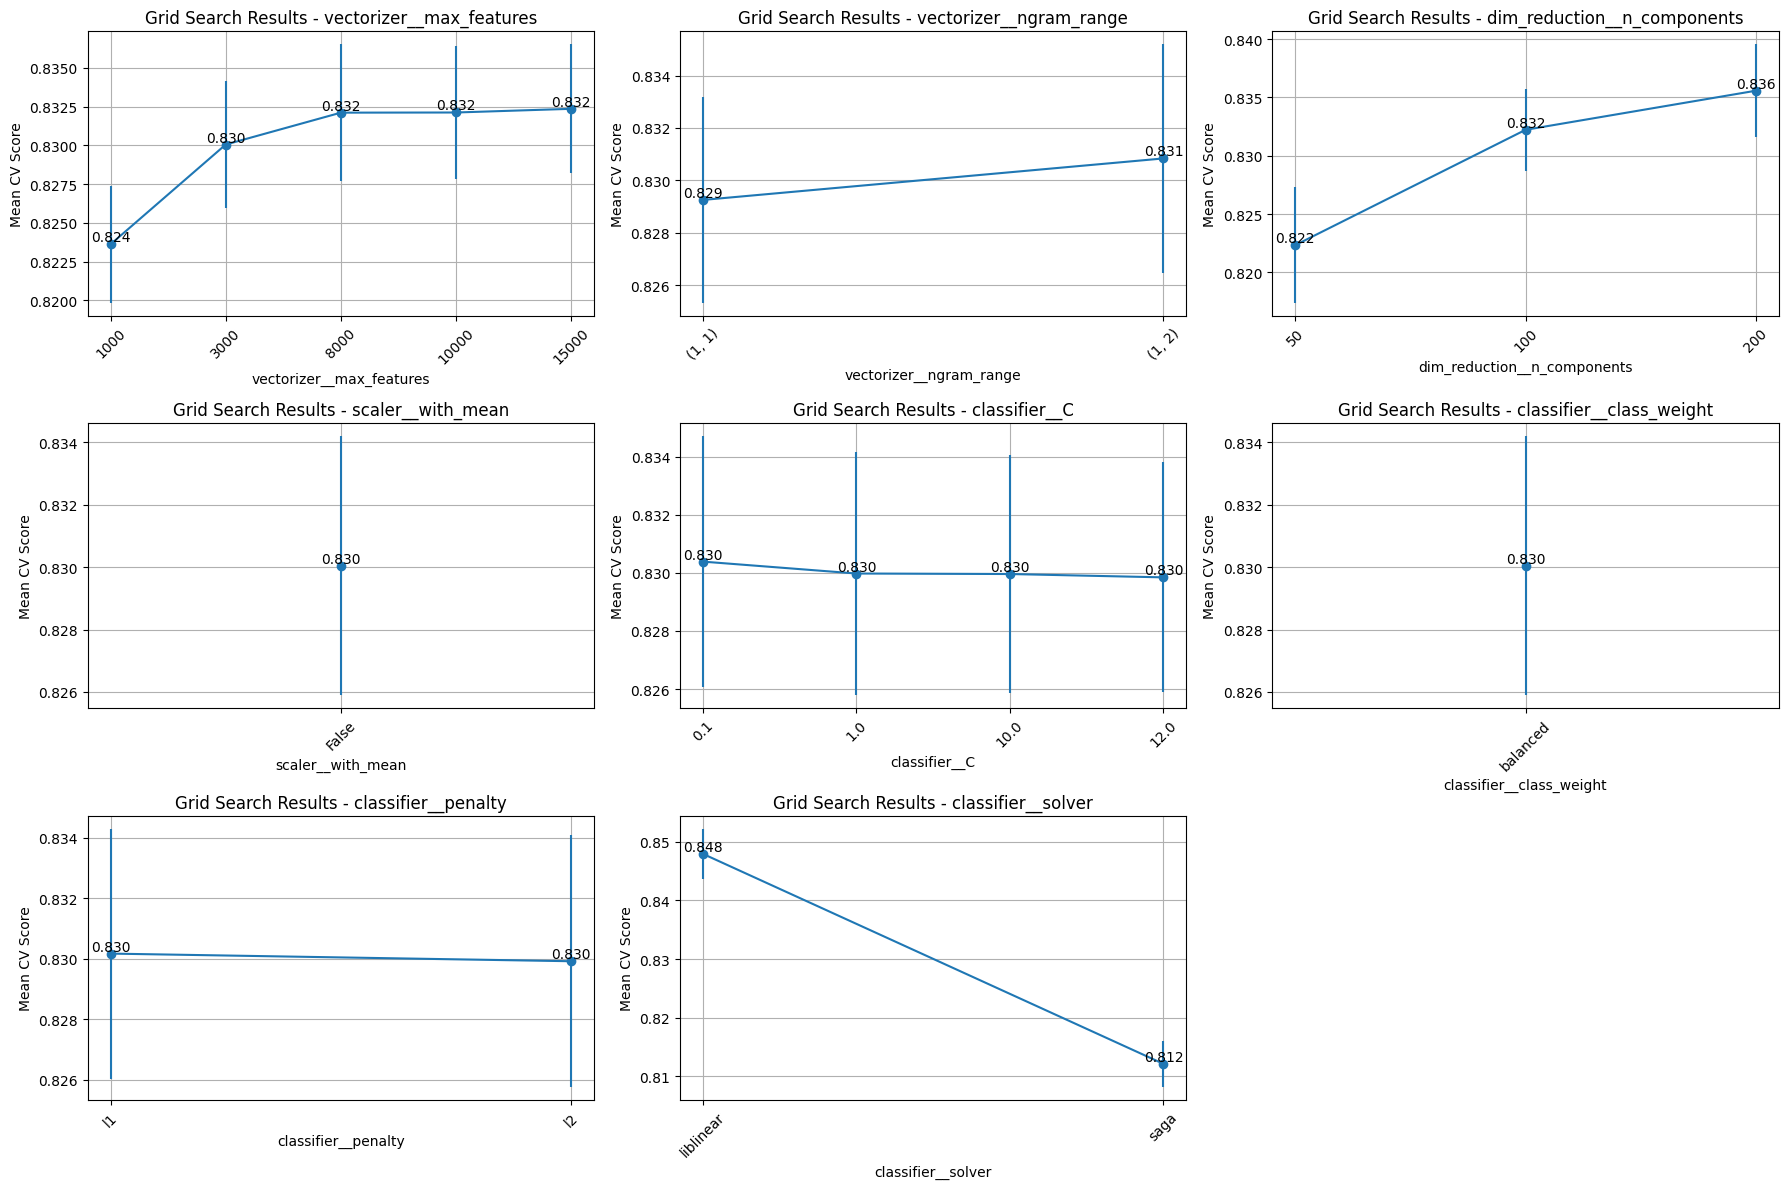


Top Features for PCA + Scaling:
Could not plot feature importance for PCA + Scaling: local variable 'importances' referenced before assignment

Class-specific Features for PCA + Scaling:


In [34]:
# Compare models
results_three = compare_models_with_grid_search(X_train_three, X_test_three, y_train_three, y_test_three)

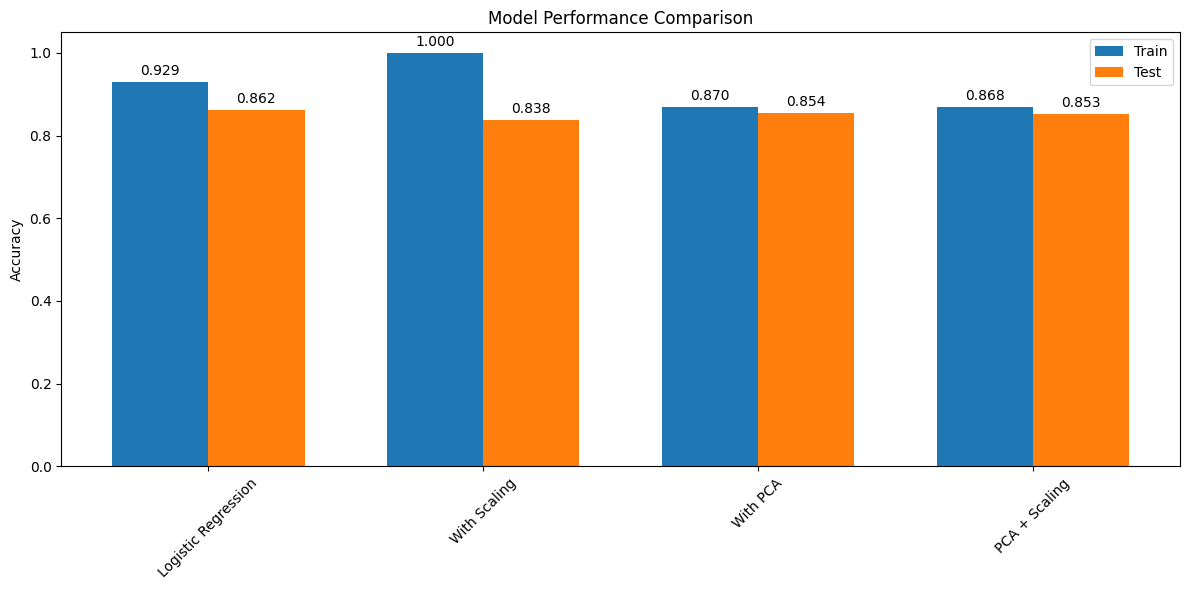

In [35]:
# Plot comparison
plot_model_comparison(results_three)